In [1]:
## import libraries
import numpy as np
import pandas as pd
import utils
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from math import sqrt
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from bs4 import BeautifulSoup
import requests
import lxml
import datetime
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from pybaseball import batting_stats_bref
from pybaseball import statcast_batter_expected_stats
from pybaseball import statcast_pitcher_expected_stats
from pybaseball import pitching_stats
from pybaseball import cache
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from scipy.optimize import minimize
import pulp
from pulp import *
import datetime
import random
import pickle
import cProfile
import time
# import logistic regression and accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from sklearn.preprocessing import normalize



import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
# cache.enable()

optional = ''

In [167]:
# functions



# get today's date formatted as yyyy-mm-dd
def get_todays_date():
  # get the current date
  today = datetime.date.today()
  # format the date as yyyy-mm-dd
  date = today.strftime('%Y-%m-%d')
  # return the date
  return date

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


def get_starters(date):
  # url for the website
  url = 'https://www.fangraphs.com/livescoreboard.aspx?date=' + date
  # get the website with bs
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  tables = soup.find_all('table', class_='lineup')

  starting = []
  for table in tables:
    row = table.find_all('tr')
    for r in row:
      col = r.find_all('td')
      for c in col:
        a = c.find_all('a')
        if len(a) > 0:
          for i in a:
            name = i.text
            # change names which are not in the correct format
            if name == 'Cedric Mullins II':
              starting.append('Cedric Mullins')
            elif name == 'Mike Siani':
              starting.append('Michael Siani')
            elif name == 'Enrique Hernandez':
              starting.append('Kike Hernandez')
            elif name == 'J.J. Bleday':
              starting.append('JJ Bleday')
            elif name == 'D.J. Stewart':
              starting.append('DJ Stewart')
            else:
              starting.append(name)


  starting_df = pd.DataFrame(starting)
  return starting_df

            
def calculate_batting_fantasy_points(row):
  points = 0
  if row['events']=='single' or row['events'] == 'walk':
    points = points + 3
  elif row['events']=='double':
    points = points + 5
  elif row['events']=='triple':
    points = points + 8
  elif row['events']=='home_run':
    points = points + 10

  points = points + 4 * (row['post_bat_score']- row['bat_score'])

  return points

def calculate_pitching_fantasy_points(row):
  points = 0
  if row['events']=='strikeout':
    points = points + 2.75
  elif row['events']=='double_play' or row['events']=='grounded_into_double_play':
    points = points + 1.5
  elif row['events']=='strikeout_double_play' or row['events']=='strikeout_double_play':
    points = points + 3.5
  elif row['events']=='triple_play':
    points = points + 2.25
  elif row['events']=='single' or row['events'] == 'walk' or row['events'] == 'hit_by_pitch' or row['events'] == 'double' or row['events'] == 'triple' or row['events'] == 'home_run':
    points = points - .6
  else:
    points = points + .75

  points = points - 2 * (row['post_bat_score']- row['bat_score'])
  return points

def total_ball_movement(row):
  # return calculation if is a number else return 0
  x = row['pfx_x']
  z = row['pfx_z']
  if np.isnan(x):
    x = 0
  if np.isnan(z):
    z = 0
  total_movement = sqrt(x**2 + z**2)
  return total_movement

def batter_adjusted_plate_x(row):
  if row['stand'] == 'R':
    return row['plate_x']
  else:
    return -row['plate_x']

# sum batter stats per team for each game
def team_batters_games(df):
  df['team'] = df.apply(batter_team, axis=1)
  team_batters = df.groupby(['game_pk', 'team'])['batter_fp'].sum().reset_index()
  return team_batters
    
# determine team based on inning_topbot
def batter_team(row):
  if row['inning_topbot'] == 'Top':
    return row['away_team']
  else:
    return row['home_team']
  
# sum pitcher stats per team for each game
def team_pitchers_games(df):
  df['team'] = df.apply(batter_team, axis=1)
  team_pitchers = df.groupby(['game_pk', 'team', 'player_name'])['pitcher_fp'].sum().reset_index()
  # get batters faced per pitcher
  batters_faced = df.groupby(['game_pk', 'team', 'player_name'])['batter'].count().reset_index()
  # merge the two dataframes
  team_pitchers = pd.merge(team_pitchers, batters_faced, on=['game_pk', 'team', 'player_name'])
  # for each game, select the pitcher with the most batters faced
  team_pitchers = team_pitchers.sort_values(by=['game_pk', 'batter'], ascending=False).drop_duplicates(subset=['game_pk', 'team'])
  return team_pitchers

# batter fantasy points by game
def batter_fp(df):
  df['batter_fp'] = df.apply(calculate_batting_fantasy_points, axis=1)

  # return points
  batter_game_fp = df.groupby(['game_pk', 'batter'])['batter_fp'].sum().reset_index()
  return batter_game_fp

# get number of plate appearances for each batter
def get_plate_appearances(df):
  plate_appearances = df.groupby(['batter'])['batter'].count().reset_index(name='pa')
  return plate_appearances

# filter the df to only the last x days
def last_x_days(df, x):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=x)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  # filter the df to only the last x days
  df = df[df['game_date'] > x_days_ago]
  return df

# fix player names to remove latin characters
def fix_player_names(df, column_name):
  df.loc[:, column_name] = df.loc[:, column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  # remove suffixes
  df = remove_suffixes(df, column_name)
  return df

# fix players names to move first name to the front and remove commas
def fix_player_names2(df, column_name):
  df[column_name] = df[column_name].str.split(',').str[1] + ' ' + df[column_name].str.split(',').str[0]
  return df

# get the frequency that a player has a stat between two values
def player_stat_frequency(df, player_name, column_name, lower, upper, is_batter=True):
  # filter the df to the selected player depending on if they are a batter or pitcher
  if is_batter:
    df = df[df['batter'] == player_name]
  else:
    df = df[df['player_name'] == player_name]

  # fix for when tyring to divide by zero
  if df.shape[0] == 0:
    return 0
  # find how often column name is between lower and upper
  freq = df[(df[column_name] >= lower) & (df[column_name] <= upper)].shape[0] / df.shape[0]
  return freq

# reformatting for merge
def convert_to_player_name(row):
  name = row['Name']
  # handle case for names with two spaces
  if len(name.split(' ')) > 2:
    return  name.split(' ')[1] + ' ' + name.split(' ')[2] + ', ' + name.split(' ')[0]
  else:
    return name.split(' ')[1] + ', ' + name.split(' ')[0]
    
# get data before date x
def data_before_date(df, y, m, d):
  x = y + "-" + m + "-" + d
  # filter the df to only the last x days
  df = df[df['game_date'] < x]
  return df


def get_batter_game_fp(pregame_info):
    # batter game fp
    batter_game_fp = batter_fp(pregame_info) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(pregame_info) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
    batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

    # filter out batters with less than 14 plate appearances
    batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    return batter_game_fp



def get_pitcher_exp(pregame_info):
    # get all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=10)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_speed', 100, 150, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)
    return pitcher_exp


def get_batter_exp(pregame_info):
    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024, 20)

    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    return batter_exp


def get_pregame_batting_order(pregame_info):
    # get only the last game for each team
    #pregame_info = pregame_info.groupby(['game_pk', 'team']).apply(lambda x: x.iloc[-1]).reset_index(drop=True)
    # get only the first at bat for each batter per game
    pregame_batting_order = pregame_info.sort_values(by=['game_pk', 'at_bat_number'])
    pregame_batting_order = pregame_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    pregame_batting_order["batting_order"] = pregame_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    pregame_batting_order = pregame_batting_order[pregame_batting_order['batting_order'] <= 9]
    return pregame_batting_order

def trim(col):
    return col.str.strip()

def remove_suffixes(df, col):
    # df[col] = df[col].str.replace(' Jr.', '')
    # df[col] = df[col].str.replace(' Sr.', '')
    # df[col] = df[col].str.replace(' II', '')
    # df[col] = df[col].str.replace(' III', '')
    # df[col] = df[col].str.replace(' IV', '')

    #do the above without chained indexing
    df.loc[:, col] = df.loc[:, col].str.replace(' Jr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' Sr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' III', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' II', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' IV', '')
    return df

def adjust_player_name(row):
  first_name = row['name_first']
  last_name = row['name_last']
  # fix names which are not in the correct format
  if last_name == 'vogelbach':
    return 'dan vogelbach'
  elif last_name == 'siani':
    return 'michael siani'
  elif first_name == 'j. d.':
    return 'j.d. martinez'
  elif row['batter_name'] == 'Michael A. Taylor':
    return 'michael taylor'

  return row['batter_name']

def filter_from_last_game_pks(df, last_game_pks):
  # remove rows in which team and game_pks pairs are not in last_game_pks
  for index, row in df.iterrows():
    if row['game_pk'] not in last_game_pks['game_pk']:
      df = df.drop(index)
    elif row['team'] not in last_game_pks['team']:
      df = df.drop(index)
    elif not(last_game_pks['team'].index_of(row['team']) == last_game_pks['game_pk'].index_of(row['game_pk'])):
      df = df.drop(index)
  return df

def get_past_date(days=30):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=days)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  return x_days_ago

def get_pitcher_averages_by_handedness(df):
  l_data = df[df['stand'] == 'L']
  r_data = df[df['stand'] == 'R']
  l_data = l_data.groupby(['Name', 'player_name']).mean(numeric_only=True).reset_index()
  r_data = r_data.groupby(['Name', 'player_name']).mean(numeric_only=True).reset_index()
  columns = l_data.columns
  columns = columns.drop(['Name', 'player_name'])
  l_data = add_suffix_to_columns(l_data, columns, '_vs_l_batter')
  r_data = add_suffix_to_columns(r_data, columns, '_vs_r_batter')
  pitcher_data = pd.merge(df, l_data, on=['Name', 'player_name'], how='left')
  pitcher_data = pd.merge(pitcher_data, r_data, on=['Name', 'player_name'], how='left')
  return pitcher_data

def get_batter_averages_by_handedness(df):
  l_data = df[df['p_throws'] == 'L']
  r_data = df[df['p_throws'] == 'R']
  l_data = l_data.groupby('batter').mean(numeric_only=True).reset_index()
  r_data = r_data.groupby('batter').mean(numeric_only=True).reset_index()
  columns = l_data.columns
  columns = columns.drop('batter')
  l_data = add_suffix_to_columns(l_data, columns, '_vs_l_pitcher')
  r_data = add_suffix_to_columns(r_data, columns, '_vs_r_pitcher')
  batter_data = pd.merge(df, l_data, on='batter', how='left')
  batter_data = pd.merge(batter_data, r_data, on='batter', how='left')
  return batter_data


def add_suffix_to_columns(df, columns, suffix):
  for col in columns:
    df = df.rename(columns={col: col + suffix})
  return df

def reduce_columns_by_handedness(df):
  # get handedness columns
  columns = df.columns
  # keep only columns containing '_vs_'
  columns = [col for col in columns if '_vs_' in col]

  for column in columns:
    # remove any that include _pitcher and _batter
    if ('_pitcher' in column) and ('_batter' in column):
      continue
    elif '_vs_l_pitcher' in column:
      new_column = column.replace('_vs_l_pitcher', '_by_pitcher_handedness')
      opposite_column = column.replace('_vs_l_pitcher', '_vs_r_pitcher')
      df[new_column] = np.where(df['p_throws'] == 'L', df[column], df[opposite_column])
    elif '_vs_l_batter' in column:
      new_column = column.replace('_vs_l_batter', '_by_batter_handedness')
      opposite_column = column.replace('_vs_l_batter', '_vs_r_batter')
      df[new_column] = np.where(df['stand'] == 'L', df[column], df[opposite_column])

  df = df.drop(columns, axis=1)
  return df

In [3]:
# get base df

# Get all Statcast data from last 30 days, previously was full year
df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# Only include events
df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
df = fix_player_names(df, 'player_name')

# get more info
df['pitcher_fp'] = df.apply(lambda row: calculate_pitching_fantasy_points(row), axis=1)
df['batter_fp'] = df.apply(lambda row: calculate_batting_fantasy_points(row), axis=1)
df['total_ball_movement'] = df.apply(lambda row: total_ball_movement(row), axis=1)
df['batter_adjusted_plate_x'] = df.apply(lambda row: batter_adjusted_plate_x(row), axis=1)

def get_pregame_info(df, year, month, day):
    df = data_before_date(df, year, month, day)
    # get team batters 
    team_batters = team_batters_games(df)

    # get team pitchers
    team_pitchers = team_pitchers_games(df)

    # get game_pks and game_dates
    game_info = df[['game_pk', 'game_date', 'away_team', 'home_team']].drop_duplicates()

    # combine team batters and team pitchers
    team_stats = pd.merge(team_batters, team_pitchers, on=['game_pk', 'team'])
    # merge with game info
    team_stats = pd.merge(team_stats, game_info, on='game_pk')
    team_stats.head()

    # get 75th percentile outcomes for batter_fp and pitcher_fp for pitchers and teams
    team_stats['batter_fp'] = team_stats['batter_fp'].astype(float)
    team_stats['pitcher_fp'] = team_stats['pitcher_fp'].astype(float)

    # use a dataframe for team-based stats that only uses data from the last 10 days
    team_info_df = last_x_days(team_stats, 10)
    team_info_df['team_fp_75'] = team_info_df.groupby('team')['batter_fp'].transform(lambda x: x.quantile(.75))
    team_info_df['opp_pitcher_fp_75'] = team_info_df.groupby('team')['pitcher_fp'].transform(lambda x: x.quantile(.75))
    team_info_df['team_fp_75'] = team_info_df['team_fp_75'].fillna(0)
    team_info_df['opp_pitcher_fp_75'] = team_info_df['opp_pitcher_fp_75'].fillna(0)

    # pitchers can have full season stats
    team_stats['pitcher_fp_75'] = team_stats.groupby('player_name')['pitcher_fp'].transform(lambda x: x.quantile(.75))
    team_stats['opp_team_fp_75'] = team_stats.groupby('player_name')['batter_fp'].transform(lambda x: x.quantile(.75))
    team_stats['pitcher_fp_75'] = team_stats['pitcher_fp_75'].fillna(0)
    team_stats['opp_team_fp_75'] = team_stats['opp_team_fp_75'].fillna(0)

    # separate teams and pitchers 75th percentiles, and drop duplicates
    pitcher_outliers = team_stats[['player_name', 'pitcher_fp_75', 'opp_team_fp_75']].drop_duplicates()
    pitcher_outliers = fix_player_names(pitcher_outliers, 'player_name')
    team_outliers = team_info_df[['team', 'team_fp_75', 'opp_pitcher_fp_75']].drop_duplicates()

    # change team from AZ to ARI and WSH to WAS
    team_outliers['team'] = team_outliers['team'].replace({'AZ': 'ARI', 'WSH': 'WAS'})

    #pitcher_outliers.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_outliers.csv', index=False)
    team_outliers.to_csv('C:\\Users\\jorda\\Downloads\\team_outliers.csv', index=False)

    # use last_x_days to filter df for recency
    # batter_recent_info = last_x_days(df, 10)

    # finding recency bias to be problematic, so we will use all data

    # batter game fp
    batter_game_fp = batter_fp(df) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(df) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
    batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

    # filter out batters with less than 14 plate appearances
    batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    batter_game_fp['batter_fp_mean'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.mean())

    # select only batter_name and batter_fp_75 and drop duplicates
    batter_outliers = batter_game_fp[['batter_name', 'batter_fp_25', 'batter_fp_75', 'batter_fp_mean', 'batter']].drop_duplicates()
    # batter_outliers.to_csv('C:\\Users\\jorda\\Downloads\\batter_outliers.csv', index=False)



    # get data for all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=10)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_speed', 100, 109, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)


    # merge with pitcher_outliers
    pitcher_exp = pd.merge(pitcher_exp, pitcher_outliers, on='player_name')
    #pitcher_exp.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_exp.csv', index=False)


    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024)
    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    # merge with batter_outliers

    batter_exp = pd.merge(batter_exp, batter_outliers, on='batter')
    #batter_exp.to_csv('C:\\Users\\jorda\\Downloads\\batter_exp.csv', index=False)


    # summarize df
    batter_summary = batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()

    # get only the first at bat for each batter per game
    batting_order = df.sort_values(by=['game_pk', 'at_bat_number'])
    batting_order = batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    batting_order["batting_order"] = batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    batting_order = batting_order[batting_order['batting_order'] <= 9]

    pitcher_exp["player_name"] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    model_data = pd.merge(batter_summary, batting_order, on=['game_pk', 'batter'])
    model_data = pd.merge(model_data, batter_exp, on='batter')
    model_data = pd.merge(model_data, pitcher_exp, on='player_name')

    pitcher_summary = df.groupby(['game_pk', 'player_name'])['pitcher_fp'].sum().reset_index()
    model_data = pd.merge(model_data, pitcher_summary, on=['game_pk', 'player_name'])


    model_data = get_pitcher_averages_by_handedness(model_data)
    model_data = get_batter_averages_by_handedness(model_data)
    game_model_outcome_data = reduce_columns_by_handedness(model_data)
    game_model_outcome_data = game_model_outcome_data.drop('pitcher_fp_x', axis=1)
    # rename batter_fp_x and pitcher_fp_y to batter_fp and pitcher_fp
    game_model_outcome_data = game_model_outcome_data.rename(columns={'batter_fp_x': 'batter_fp', 'pitcher_fp_y': 'pitcher_fp'})
    # get columns that have suffix _y
    cols = [col for col in game_model_outcome_data.columns if '_y' in col]
    # get rid of columns that have suffix _y and change _x to ''
    game_model_outcome_data = game_model_outcome_data.drop(columns=cols).rename(columns=lambda x: x.replace('_x', ''))
    return game_model_outcome_data

game_model_outcome_data = get_pregame_info(df, year, month, day)


This is a large query, it may take a moment to complete


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]


In [4]:


batter_predictive_pregame_features = ['batter_fp_mean','batting_order_by_pitcher_handedness', 'est_slg', 'est_woba', 'batter_fp_25_by_pitcher_handedness', 'batter_fp_75_by_pitcher_handedness', 'WHIP', 'Stuff+', 'Location+', 'Pitching+', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness']
pitcher_predictive_pregame_features = ['batter_fp_mean', 'WHIP', 'Stuff+', 'Location+', 'Pitching+', 'est_slg', 'est_woba', 'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp_75_by_batter_handedness', 'opp_team_fp_75']

# set clip values for all features which will be used in predictive models
clip_values = {
    'batter_fp_mean': (0, 16),
    'batting_order_by_pitcher_handedness': (1, 9),
    'batting_order': (1, 9),
    'est_slg': (0.150, 0.550),
    'est_woba': (0.200, 0.400),
    'batter_fp_25_by_pitcher_handedness': (0, 7),
    'batter_fp_75_by_pitcher_handedness': (3, 22),
    'WHIP': (0.8, 2),
    'Stuff+': (85, 115),
    'Location+': (85, 115),
    'Pitching+': (85, 115),
    'hr_friendly_launch_speed_freq': (0, 0.35),
    'hr_friendly_launch_angle_freq': (0, 0.35),
    'hr_friendly_launch_speed_pitcher': (0, 0.35),
    'hr_friendly_launch_angle_pitcher': (0, 0.35),
    'batter_fp_25_by_batter_handedness': (0, 7),
    'batter_fp_75_by_batter_handedness': (3, 22),
    'pitcher_fp_75_by_batter_handedness': (7, 28),
    'opp_team_fp_75': (50, 100),
    'teams_in_game_pk': (2, 30),
    'is_of': (0, 1),
    'team_batter_fp_pred': (45,115),
    'pitcher_salary': (4000, 13000),
    'batter_salary': (2000, 7000),
    'pitcher_value': (0, 0.004),
    'team_batter_salary': (0, 60000)
}

In [5]:
def normalize_features(data):
    normalized_data = data.copy()
    features = []
    for feature in clip_values:
        if feature in normalized_data.columns:
            features.append(feature)
            normalized_data[feature] = normalized_data[feature].clip(clip_values[feature][0], clip_values[feature][1])
    normalized_data[features] = normalize(normalized_data[features])
    return normalized_data

In [24]:
# get batter and pitcher fp models using predictive features; make it a keras model
def get_normalized_model(data, target, features):
    normalized_data = data.copy()
    # clip values
    for feature in features:
        normalized_data[feature] = normalized_data[feature].clip(clip_values[feature][0], clip_values[feature][1])
        
    # normalize data
    normalized_data[features] = normalize(normalized_data[features])


    # # create a tensorflow model to predict payoff for each player
    # X = normalized_data[features]
    # y = normalized_data[target]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # model = keras.Sequential([
    #     layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    #     layers.Dense(64, activation='relu'),
    #     layers.Dense(1)
    # ])

    # model.compile(
    #     optimizer='adam',
    #     loss='mean_squared_error'
    # )

    # history = model.fit(
    #     X_train, y_train,
    #     validation_data=(X_test, y_test),
    #     batch_size=256,
    #     epochs=100
    # )
    # y_pred = model.predict(X_test)
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Model R2: ', r2)
    # print('Model RMSE: ', rmse)
    # return model
    return get_linear_model(normalized_data, target, features)

    

def get_linear_model(data, target, features):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return model


In [25]:

batter_fp_model = get_normalized_model(game_model_outcome_data, 'batter_fp', batter_predictive_pregame_features)
pitcher_fp_model = get_normalized_model(game_model_outcome_data, 'pitcher_fp', pitcher_predictive_pregame_features)


Model R2:  0.043740159599128914
Model RMSE:  7.285820149534426
Model R2:  0.17169952005193778
Model RMSE:  8.902209368029984


Analysis of Past Slates

In [26]:
# # get draftkings salaries based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLBMMDDYYYY.csv"
# def get_pregame_info(df, year, month, day):
#     pregame_info = data_before_date(df, year, month, day)

#     pregame_batter_game_fp = get_batter_game_fp(pregame_info)
#     pregame_pitcher_exp = get_pitcher_exp(pregame_info)
#     pregame_batter_exp = get_batter_exp(pregame_info)

#     # summarize df
#     pregame_batter_summary = pregame_batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()


#     pregame_batting_order = get_pregame_batting_order(pregame_info)

#     # get batter, game_pk, and batting order from pregame_batting_order
#     pregame_batting_order = get_pregame_batting_order(pregame_info)
#     pregame_batting_order = pregame_batting_order[['batter', 'game_pk', 'batting_order', 'player_name']]

#     # merge all pregame data
#     pregame_data = pd.merge(pregame_batter_summary, pregame_batting_order, on=['game_pk', 'batter'], how='left')
#     pregame_data = pd.merge(pregame_data, pregame_batter_exp, on='batter', how='left')

#     pregame_data = pd.merge(pregame_data, pregame_pitcher_exp, on='player_name', how='left')

#     # add pitcher_fp to pregame_data
#     pregame_data = pd.merge(pregame_data, pitcher_summary, on=['game_pk', 'player_name'], how='left')

#     pregame_data = fix_player_names(pregame_data, 'batter_name')
#     pregame_data = fix_player_names(pregame_data, 'player_name')

#     pregame_batter_game_fp_mean = pregame_data[['batter_name', 'batting_order', 'batter_fp']]
#     pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.groupby('batter_name').mean().reset_index()
#     pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.rename(columns={'batting_order': 'avg_batting_order', 'batter_fp': 'avg_batter_fp'})
#     # merge the two dataframes
#     pregame_data = pd.merge(pregame_data, pregame_batter_game_fp_mean, on='batter_name', how='left')
#     # add a column for the change in batting order
#     pregame_data['batting_order_change'] = pregame_data['avg_batting_order'] - pregame_data['batting_order']

#     # drop columns with missing values
#     pregame_data = pregame_data.dropna()
    
#     pregame_data = get_pitcher_averages_by_handedness(pregame_data)
#     pregame_data = get_batter_averages_by_handedness(pregame_data)
#     pregame_data = reduce_columns_by_handedness(pregame_data)
#     return pregame_data

def get_dk_salaries(year, month, day, optional=""):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\DKSalariesMLB" + month + day + year + optional + ".csv"
    print(string)
    salaries = pd.read_csv(string)
    return salaries

# get contest standings based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandingsMMDDYYYY.csv"
def get_contest_standings(year, month, day):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\MLBContestStandings" + month + day + year + ".csv"
    print(string)
    contest_data = pd.read_csv(string)
    return contest_data

def get_contest_results(contest_data):
    contest_player_results = contest_data[['Player', '%Drafted', 'FPTS']]
    # drop nas
    contest_player_results = contest_player_results.dropna()
    # convert %Drafted to a float
    contest_player_results['%Drafted'] = contest_player_results['%Drafted'].str.replace('%', '').astype(float)
    # convert FPTS to a float
    contest_player_results['FPTS'] = contest_player_results['FPTS'].astype(float)
    # fix player names
    contest_player_results = fix_player_names(contest_player_results, 'Player')
    # remove suffixes
    contest_player_results = remove_suffixes(contest_player_results, 'Player')
    return contest_player_results

def get_leaderboard(contest_data):
    leaderboard = contest_data[['Rank', 'Points', 'Lineup']]
    leaderboard = leaderboard.dropna()
    # convert Points to a float
    leaderboard['Points'] = leaderboard['Points'].astype(float)
    return leaderboard

# get files in folder "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\" and return their names
def get_files():
    files = []
    for file in os.listdir("C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\"):
        if file.endswith(".csv"):
            files.append(file)
    return files

In [27]:
#data_before_date(game_model_outcome_data, '2024', '06', '05')

In [28]:

def compile_data_from_date(df, year, month, day):
   # merge dk salaries with pregame_data by batter_name
    salaries = get_dk_salaries(year, month, day, "")

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # only keep Name and Salary for pitchers
    pitcher_salaries = pitcher_salaries[['Name', 'Salary', 'TeamAbbrev']]
    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name', 'TeamAbbrev':'pitcher_team'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})

    this_day_statcast = statcast(start_dt=year + '-' + month + '-' + day, end_dt=year + '-' + month + '-' + day)
    # set 'team' as home_team if inning_topbot is 'Bot', and away_team if 'Top'
    this_day_statcast['team'] = this_day_statcast.apply(team, axis=1)
    # get only the first at bat for each batter per game
    this_day_batting_order = this_day_statcast.sort_values(by=['game_pk', 'at_bat_number'])
    this_day_batting_order = this_day_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    this_day_batting_order["batting_order"] = this_day_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    this_day_batting_order = this_day_batting_order[this_day_batting_order['batting_order'] <= 9]

    # get batter_name for this_day_batting_order
    batter_ids = this_day_batting_order['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge this_day_batting_order with batter_name_id_pairs
    this_day_batting_order = pd.merge(this_day_batting_order, batter_name_id_pairs, on='batter')

    # get pitcher_name for this_day_batting_order based on player_name
    this_day_batting_order = fix_player_names(this_day_batting_order, 'player_name')
    this_day_batting_order= fix_player_names2(this_day_batting_order, 'player_name')
    # rename player_name to Name
    this_day_batting_order = this_day_batting_order.rename(columns={'player_name': 'Name'})
    # merge with pitcher_salaries
    bo_with_salaries = pd.merge(this_day_batting_order, hitter_salaries)
    # only keep Name, team, batting_order, batter_name, Roster Position, Salary
    bo_with_salaries = bo_with_salaries[['Name', 'team', 'batting_order', 'batter_name', 'Roster Position', 'Salary']]
    bo_with_salaries = bo_with_salaries.rename(columns={'Salary': 'batter_salary'})
    bo_with_salaries = bo_with_salaries.rename(columns={'Name': 'pitcher_name'})
    # trim pitcher_name in bo_with_salaries
    bo_with_salaries['pitcher_name'] = trim(bo_with_salaries['pitcher_name'])
    # merge with pitcher_salaries
    new_merge = pd.merge(bo_with_salaries, pitcher_salaries, on='pitcher_name')


    # use historic data to determine hitter and pitcher quality, with the goal of predicting batter_fp and pitcher_fp
    pregame_data = get_pregame_info(df, year, month, day)

    # get pitcher names, plus WHIP, Pitching+
    pitcher_names = pregame_data[['player_name'] + pitcher_predictive_pregame_features]
    # rename player_name to pitcher_name
    pitcher_names = pitcher_names.rename(columns={'player_name': 'pitcher_name'})
    # fix names
    pitcher_names = fix_player_names(pitcher_names, 'pitcher_name')
    pitcher_names = fix_player_names2(pitcher_names, 'pitcher_name')
    # trim names
    pitcher_names['pitcher_name'] = trim(pitcher_names['pitcher_name'])
    # drop duplicates
    pitcher_names = pitcher_names.drop_duplicates()
    # get batter names, plus 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp'
    batter_names = pregame_data[['batter_name'] + batter_predictive_pregame_features]
    # trim names
    batter_names['batter_name'] = trim(batter_names['batter_name'])
    # drop duplicates
    batter_names = batter_names.drop_duplicates()

    # merge with new_merge by names to set up predictions
    all_data = pd.merge(new_merge, pitcher_names, on='pitcher_name')
    all_data = pd.merge(all_data, batter_names, on='batter_name')

    # keep drop suffixed by _y and rename _x to ''
    cols = [col for col in all_data.columns if '_y' in col]
    all_data = all_data.drop(columns=cols).rename(columns=lambda x: x.replace('_x', ''))

    all_data['batter_fp_pred'] = batter_fp_model.predict(normalize_features(all_data[batter_predictive_pregame_features]))

    teams_in_game_pk = all_data['team'].unique()
    all_data['teams_in_game_pk'] = teams_in_game_pk.size
    # get is_of
    all_data['is_of'] = all_data['Roster Position'].apply(lambda x: 1 if x == 'OF' else 0)
    # get team_batter_fp_pred
    team_batter_fp_pred = all_data.groupby('team')['batter_fp_pred'].mean().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data = pd.merge(all_data, team_batter_fp_pred, on='team')

    all_data['pitcher_fp_pred'] = pitcher_fp_model.predict(normalize_features(all_data[pitcher_predictive_pregame_features]))


    # # select only pitcher_name and pitcher_fp_pred, then merge with all_data
    # pitcher_data = pitcher_data[['pitcher_name', 'pitcher_fp_pred']]
    # all_data = pd.merge(all_data, pitcher_data, on='pitcher_name')

    # use leaderboard and results to determine the success of each player
    contest_data = get_contest_standings(year, month, day)
    contest_player_results = get_contest_results(contest_data)
    leaderboard = get_leaderboard(contest_data)

    # Establish payoffs for each player based on their performance as well as their appearance in the leaderboard's top 100
    # get the top 20 lineups
    top_20 = leaderboard.head(20)
    # get all players in the all_data dataframe
    all_players = all_data['batter_name'].unique()
    # get pitchers as well
    pitchers = all_data['pitcher_name'].unique()
    # combine those vectors
    all_players = np.concatenate((all_players, pitchers))

    # enumerate payoffs for placements in the top 20
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]

    # create a dictionary for player payoffs
    player_payoffs = {}

    # for each lineup in top_20, look for each player in all_players and increase their payoff by the corresponding value in payoffs if found
    for index, row in top_20.iterrows():
        lineup = row['Lineup']
        for player in all_players:
            if player in lineup:
                if player in player_payoffs:
                    player_payoffs[player] += payoffs[index]
                else:
                    player_payoffs[player] = payoffs[index]

    # for each player in all_players, if they are not in player_payoffs, set their payoff to 0
    for player in all_players:
        if player not in player_payoffs:
            player_payoffs[player] = 0

    # add player payoffs to all_data
    all_data['payoff'] = all_data['batter_name'].map(player_payoffs)

    # add pitcher payoffs to all_data
    all_data['pitcher_payoff'] = all_data['pitcher_name'].map(player_payoffs)


    # add contest results to all_data
    all_data_with_results = pd.merge(all_data, contest_player_results, left_on='batter_name', right_on='Player', how='left')
    # rename %drafted to batter_drafted and FPTS to batter_fpts
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'batter_drafted', 'FPTS': 'batter_fpts'})
    # drop Player column
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # do the same for pitchers
    all_data_with_results = pd.merge(all_data_with_results, contest_player_results, left_on='pitcher_name', right_on='Player', how='left')
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'pitcher_drafted', 'FPTS': 'pitcher_fpts'})
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # divide payoff and pitcher_payoff by (leaderboard_size * percent_drafted) to get payoff per usage
    leaderboard_size = leaderboard.shape[0]
    all_data_with_results['payoff'] = all_data_with_results['payoff'] / (leaderboard_size * all_data_with_results['batter_drafted']/100)
    all_data_with_results['pitcher_payoff'] = all_data_with_results['pitcher_payoff'] / (leaderboard_size * all_data_with_results['pitcher_drafted']/100)

    # get mean drafted % by team for pitchers
    team_pitcher_drafted = all_data_with_results.groupby('team')['pitcher_drafted'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted': 'opp_pitcher_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_pitcher_drafted, on='team')

    # get mean drafted % by pitcher_team for batters
    team_batter_drafted = all_data_with_results.groupby('pitcher_team')['batter_drafted'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted': 'opp_batter_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_drafted, on='pitcher_team')

    # add a column for team_batter_fp_pred
    team_batter_fp_pred = all_data_with_results.groupby('team')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_fp_pred, on='team')
    
    # add game_date to all_data_with_results
    all_data_with_results['game_date'] = year + '-' + month + '-' + day

    return all_data_with_results


def get_opposing_team(team, game_info):
    # if game info includes Postponed or game_info dtype is float return None
    if game_info == 'Postponed':
        return None
    if type(game_info) == float:
        return None
    # get the opposing team from the game_info
    matchup = game_info.split(' ')[0]
    teams = matchup.split('@')
    if teams[0] == team:
        return teams[1]
    else:
        return teams[0]


In [29]:
def get_all_data_from_draftkings():
    # run compile_data_from_date for all dates and combine the results into a single dataframe
    all_data = pd.DataFrame()
    files = get_files()

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            
            all_data = pd.concat([all_data, compile_data_from_date(df, y, m, d)])

    # drop NaNs
    all_data = all_data.dropna()
    # add a column with value 1 if Roster Position contains OF or /
    all_data['is_of'] = all_data['Roster Position'].str.contains('OF|/').astype(int)

    # save all_data to csv in case of loss
    all_data.to_csv('C:\\Users\\jorda\\Downloads\\all_data.csv', index=False)


Below, use to get all old contest data; should not be run more than once per day as all data can be read from CSV

In [30]:
# uncomment the line below to get all data from DraftKings
# get_all_data_from_draftkings()

In [31]:
def get_all_data_plus_team_batter_fp_pred():
    # read from all_data to save time
    all_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_data.csv')

    # get team_batter_fp_pred
    team_batter_fp_pred = all_data.groupby(['team', 'pitcher_name'])['batter_fp_pred'].mean().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data = pd.merge(all_data, team_batter_fp_pred, on=['team', 'pitcher_name'])

    # multiply by 9 for team_batter_fp_pred
    all_data['team_batter_fp_pred'] = all_data['team_batter_fp_pred'] * 9
    return all_data

all_data = get_all_data_plus_team_batter_fp_pred()


In [32]:
# drop duplicates
all_data = all_data.drop_duplicates(subset=['game_date', 'batter_name', 'pitcher_name', 'team', 'pitcher_team'])
all_data.head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Stuff+,Location+,Pitching+,est_slg,est_woba,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batting_order_by_pitcher_handedness,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,batter_fp_pred,teams_in_game_pk,is_of,team_batter_fp_pred_x,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred_y,game_date,team_batter_fp_pred
0,Jack Flaherty,TOR,6.0,George Springer,OF,4000,8400,DET,1.00,96,104,104,0.336,0.265,1.163793,9.620690,0.136986,0.054795,0.119266,0.059633,23.2500,79.0,1.500000,1.5,7.50,6.100633,4,1,6.921638,16.164364,5.543019,1.630363,15.20,2.0,57.42,21.45,57.42,21.403540,61291.10,2024-05-23,62.294738
1925,Kevin Gausman,DET,5.0,Gio Urshela,3B,3000,8000,TOR,1.27,96,105,106,0.360,0.272,1.714286,10.196429,0.141791,0.044776,0.178010,0.078534,18.8375,91.5,5.571429,0.0,6.25,4.815619,4,0,6.106015,12.065726,0.000000,35.836879,26.74,0.0,52.82,32.50,52.82,22.806318,62592.76,2024-05-23,54.954137
2894,Jack Flaherty,TOR,2.0,Danny Jansen,C,4700,8400,DET,1.00,96,104,104,0.336,0.265,1.163793,9.620690,0.136986,0.054795,0.119266,0.059633,23.2500,79.0,5.571429,3.0,13.00,7.782893,4,0,6.921638,16.164364,49.973866,1.630363,32.82,16.0,57.42,21.45,57.42,21.403540,61291.10,2024-05-23,62.294738
3939,Jack Flaherty,TOR,7.0,Daulton Varsho,OF,4400,8400,DET,1.00,96,104,104,0.336,0.265,1.163793,9.620690,0.136986,0.054795,0.119266,0.059633,23.2500,79.0,7.166667,3.0,11.00,6.843970,4,1,6.921638,16.164364,36.417583,1.630363,13.47,16.0,57.42,21.45,57.42,21.403540,61291.10,2024-05-23,62.294738
5974,Kevin Gausman,DET,2.0,Matt Vierling,3B/OF,3700,8000,TOR,1.27,96,105,106,0.360,0.272,1.714286,10.196429,0.141791,0.044776,0.178010,0.078534,18.8375,91.5,4.722222,1.5,8.50,6.048949,4,1,6.106015,12.065726,0.000000,35.836879,32.56,3.0,52.82,32.50,52.82,22.806318,62592.76,2024-05-23,54.954137


In [33]:
# get other needed data for models
# batter_fp_mean
batter_fp_mean = all_data.groupby('batter_name')['batter_fp_pred'].mean().reset_index()
batter_fp_mean = batter_fp_mean.rename(columns={'batter_fp_pred': 'batter_fp_mean'})
all_data = pd.merge(all_data, batter_fp_mean, on='batter_name')

Batter Drafted % Linear Regression model

In [34]:
# model batter_drafted from all_data

# do the same as payoff models using keras and all available numeric columns
# get all numerical columns
batter_drafted_features = batter_predictive_pregame_features + ['teams_in_game_pk', 'is_of', 'team_batter_fp_pred']
target = 'batter_drafted'

batter_drafted_model = get_normalized_model(all_data, target, batter_drafted_features)

Model R2:  0.3927041840652816
Model RMSE:  4.207788902755594


In [35]:
def add_batter_ownership(all_data=all_data, batter_drafted_model=batter_drafted_model):
    # create a copy of all_data and add the predicted ownership to it
    all_data_with_ownership = all_data.copy()
    all_data_with_ownership['batter_drafted_pred'] = batter_drafted_model.predict(normalize_features(all_data[batter_drafted_features]))
    all_data_with_ownership['batter_drafted_pred'] = all_data_with_ownership['batter_drafted_pred']
    all_data_with_ownership.head()
    return all_data_with_ownership

all_data_with_ownership = add_batter_ownership()

In [36]:
# # reduce df to pitcher name, batter_salary, pitcher_salary, WHIP, Pitching+, team, pitcher_fp_pred, pitcher_drafted, team_batter_fp_pred, and teams_in_game_pk; get sum of batter_salary and mean of everything else
# pitcher_data = all_data_with_ownership[['pitcher_name', 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'team', 'pitcher_fp_pred', 'pitcher_drafted', 'team_batter_fp_pred', 'teams_in_game_pk']]
# pitcher_data = pitcher_data.groupby(['pitcher_name', 'pitcher_drafted']).agg({'batter_salary': 'sum', 'pitcher_salary': 'mean', 'WHIP': 'mean', 'Pitching+': 'mean', 'pitcher_fp_pred': 'mean', 'team_batter_fp_pred': 'mean', 'teams_in_game_pk': 'mean'}).reset_index()
# # merge this with unique pitcher_name and pitcher_drafted
# pitcher_data.head()

In [37]:
# linear regression model to predict pitcher_drafted
# rename batter_salary to team_batter_salary
pitcher_drafted_features = ['batter_salary', 'pitcher_salary','team_batter_fp_pred', 'teams_in_game_pk'] + pitcher_predictive_pregame_features
target = 'pitcher_drafted'

pitcher_data = all_data_with_ownership[['pitcher_name', 'batter_salary', 'pitcher_salary', 'team_batter_fp_pred', 'teams_in_game_pk'] + pitcher_predictive_pregame_features + [target]]
# map batter_salary to sum and all else to mean
agg_types = {}
for feature in pitcher_drafted_features:
    if feature == 'batter_salary':
        agg_types[feature] = 'sum'
    elif feature == 'pitcher_name':
        agg_types[feature] = 'first'
    else:
        agg_types[feature] = 'mean'
pitcher_data = pitcher_data.groupby(['pitcher_name', target]).agg(agg_types).reset_index()

pitcher_drafted_model = get_normalized_model(pitcher_data, target, pitcher_drafted_features)

Model R2:  0.43898026437013815
Model RMSE:  11.530422504227289


In [38]:

# get team_batter_salary for all_data_with_ownership
team_batter_salary = all_data_with_ownership.groupby('team')['batter_salary'].sum().reset_index()
team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
all_data_with_ownership = pd.merge(all_data_with_ownership, team_batter_salary, on='team')

# add pitcher_drafted_pred to all_data_with_ownership
all_data_with_ownership['pitcher_drafted_pred'] = pitcher_drafted_model.predict(normalize_features(all_data_with_ownership[pitcher_drafted_features]))


In [39]:
all_data_with_ownership.head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Stuff+,Location+,Pitching+,est_slg,est_woba,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batting_order_by_pitcher_handedness,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,batter_fp_pred,teams_in_game_pk,is_of,team_batter_fp_pred_x,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred_y,game_date,team_batter_fp_pred,batter_fp_mean,batter_drafted_pred,team_batter_salary,pitcher_drafted_pred
0,Jack Flaherty,TOR,6.0,George Springer,OF,4000,8400,DET,1.00,96,104,104,0.336,0.265,1.163793,9.620690,0.136986,0.054795,0.119266,0.059633,23.2500,79.0,1.500000,1.5,7.50,6.100633,4,1,6.921638,16.164364,5.543019,1.630363,15.20,2.0,57.42,21.45,57.42,21.403540,61291.10,2024-05-23,62.294738,6.383476,9.057443,376000,27.057198
1,Kevin Gausman,DET,5.0,Gio Urshela,3B,3000,8000,TOR,1.27,96,105,106,0.360,0.272,1.714286,10.196429,0.141791,0.044776,0.178010,0.078534,18.8375,91.5,5.571429,0.0,6.25,4.815619,4,0,6.106015,12.065726,0.000000,35.836879,26.74,0.0,52.82,32.50,52.82,22.806318,62592.76,2024-05-23,54.954137,5.435586,10.436275,268600,32.738894
2,Jack Flaherty,TOR,2.0,Danny Jansen,C,4700,8400,DET,1.00,96,104,104,0.336,0.265,1.163793,9.620690,0.136986,0.054795,0.119266,0.059633,23.2500,79.0,5.571429,3.0,13.00,7.782893,4,0,6.921638,16.164364,49.973866,1.630363,32.82,16.0,57.42,21.45,57.42,21.403540,61291.10,2024-05-23,62.294738,7.171210,10.532485,376000,24.911703
3,Jack Flaherty,TOR,7.0,Daulton Varsho,OF,4400,8400,DET,1.00,96,104,104,0.336,0.265,1.163793,9.620690,0.136986,0.054795,0.119266,0.059633,23.2500,79.0,7.166667,3.0,11.00,6.843970,4,1,6.921638,16.164364,36.417583,1.630363,13.47,16.0,57.42,21.45,57.42,21.403540,61291.10,2024-05-23,62.294738,7.106755,9.067932,376000,25.134514
4,Kevin Gausman,DET,2.0,Matt Vierling,3B/OF,3700,8000,TOR,1.27,96,105,106,0.360,0.272,1.714286,10.196429,0.141791,0.044776,0.178010,0.078534,18.8375,91.5,4.722222,1.5,8.50,6.048949,4,1,6.106015,12.065726,0.000000,35.836879,32.56,3.0,52.82,32.50,52.82,22.806318,62592.76,2024-05-23,54.954137,7.040499,10.915139,268600,27.480337


In [40]:

# add 'value' to all_data_with_ownership
all_data_with_ownership['batter_value'] = all_data_with_ownership['batter_fp_pred'] / all_data_with_ownership['batter_salary']
all_data_with_ownership['pitcher_value'] = all_data_with_ownership['pitcher_fp_pred'] / all_data_with_ownership['pitcher_salary']
# use all numeric columns
batter_payoff_model_features = ['batting_order', 'batter_salary', 'WHIP', 'Stuff+', 'Location+', 'Pitching+', 'est_slg', 'est_woba', 'batter_fp_25_by_pitcher_handedness', 'batter_fp_75_by_pitcher_handedness', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness', 'team_batter_fp_pred', 'teams_in_game_pk', 'is_of', 'team_batter_salary', 'teams_in_game_pk']






In [41]:
batter_payoff_model = get_normalized_model(all_data_with_ownership, 'payoff', batter_payoff_model_features)


Model R2:  -0.09168233558746786
Model RMSE:  25.963853469805265


In [42]:
# do the same as above for pitcher_payoff

pitcher_payoff_model_features = ['pitcher_salary', 'WHIP', 'opp_team_fp_75', 'Pitching+', 'Stuff+', 'Location+', 'hr_friendly_launch_speed_pitcher', 'pitcher_fp_75_by_batter_handedness', 'opp_team_fp_75', 'team_batter_fp_pred', 'teams_in_game_pk', 'pitcher_value']

pitcher_payoff_model = get_normalized_model(all_data_with_ownership, 'pitcher_payoff', pitcher_payoff_model_features)

Model R2:  -0.030778168802668704
Model RMSE:  11.38126762951694


In [43]:
# show which players correspond to the highest predicted payoffs
all_data_with_payoff_pred  = all_data_with_ownership.copy()
all_data_with_payoff_pred['payoff_pred'] = batter_payoff_model.predict(normalize_features(all_data_with_payoff_pred[batter_payoff_model_features]))
all_data_with_payoff_pred = all_data_with_payoff_pred.sort_values(by='payoff_pred', ascending=False)


In [44]:
all_data_with_payoff_pred.head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Stuff+,Location+,Pitching+,est_slg,est_woba,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batting_order_by_pitcher_handedness,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,batter_fp_pred,teams_in_game_pk,is_of,team_batter_fp_pred_x,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred_y,game_date,team_batter_fp_pred,batter_fp_mean,batter_drafted_pred,team_batter_salary,pitcher_drafted_pred,batter_value,pitcher_value,payoff_pred
752,Trevor Richards,BAL,4.0,Anthony Santander,OF,4600,5700,TOR,0.86,90,95,100,0.339,0.261,0.0,7.0,0.195652,0.043478,0.089286,0.089286,6.3,33.0,4.117647,3.0,10.75,7.492603,19,1,8.659774,8.451052,28.261263,0.0,7.04,7.0,0.12,12.5,0.12,5.950204,4243.289,2024-06-04,77.937965,7.598220,1.911560,523300,-17.313762,0.001629,0.001483,45.692941
758,Trevor Richards,BAL,5.0,Jordan Westburg,2B/3B,5000,5700,TOR,0.86,90,95,100,0.339,0.261,0.0,7.0,0.195652,0.043478,0.089286,0.089286,6.3,33.0,4.529412,3.0,14.00,8.648140,19,1,8.659774,8.451052,11.232705,0.0,4.36,0.0,0.12,12.5,0.12,5.950204,4243.289,2024-06-04,77.937965,8.585958,3.046336,523300,-17.550711,0.001730,0.001483,45.193104
755,Trevor Richards,BAL,3.0,Ryan Mountcastle,1B,4900,5700,TOR,0.86,90,95,100,0.339,0.261,0.0,7.0,0.195652,0.043478,0.089286,0.089286,6.3,33.0,3.000000,3.0,12.00,8.136926,19,0,8.659774,8.451052,37.821289,0.0,5.39,34.0,0.12,12.5,0.12,5.950204,4243.289,2024-06-04,77.937965,8.111001,3.087649,523300,-16.881154,0.001661,0.001483,44.750173
757,Trevor Richards,BAL,2.0,Adley Rutschman,C,5600,5700,TOR,0.86,90,95,100,0.339,0.261,0.0,7.0,0.195652,0.043478,0.089286,0.089286,6.3,33.0,2.000000,3.0,13.50,8.855192,19,0,8.659774,8.451052,12.760130,0.0,4.03,16.0,0.12,12.5,0.12,5.950204,4243.289,2024-06-04,77.937965,8.874082,3.910231,523300,-14.233625,0.001581,0.001483,43.559904
760,Trevor Richards,BAL,1.0,Gunnar Henderson,SS,6100,5700,TOR,0.86,90,95,100,0.339,0.261,0.0,7.0,0.195652,0.043478,0.089286,0.089286,6.3,33.0,1.352941,3.0,17.00,10.261856,19,0,8.659774,8.451052,20.429243,0.0,8.81,15.0,0.12,12.5,0.12,5.950204,4243.289,2024-06-04,77.937965,10.082464,5.521865,523300,-13.795985,0.001682,0.001483,41.696078


In [45]:
features_from_batters = ['batting_order_by_pitcher_handedness',
 'est_slg',
 'est_woba',
 'batter_fp_25_by_pitcher_handedness',
 'batter_fp_75_by_pitcher_handedness',
 'hr_friendly_launch_speed_freq',
 'hr_friendly_launch_angle_freq'
 ]

features_from_pitchers = ['WHIP','Stuff+',
 'Location+',
 'Pitching+','hr_friendly_launch_speed_pitcher',
 'hr_friendly_launch_angle_pitcher',
 'pitcher_fp_75_by_batter_handedness',
 'opp_team_fp_75','batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness']

Get data for today, and apply knowledge from the past to predict payoffs

In [46]:
def get_todays_data(year, month, day, optional='', pregame_data=game_model_outcome_data, df=df):
    print('Year: ', year, 'Month: ', month, 'Day: ', day, 'Optional: ', optional)
    # get salaries for today
    todays_salaries = get_dk_salaries(year, month, day, optional)

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
    # fixnames
    salaries = fix_player_names(salaries, 'Name')

    # remove Jr., Sr., II, and III from names
    salaries = remove_suffixes(salaries, 'Name')

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
    hitter_salaries.reset_index(drop=True, inplace=True)

    # get batting orders from get_starters, or by using the last game_pk for the team in df
    starters = get_starters(year+'-'+month+'-'+day)
    starters = fix_player_names(starters, 0)
    # rename starters to batter_name
    starters = starters.rename(columns={0: 'batter_name'})

    # trim hitter_salaries
    hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
    # trim starters
    starters['batter_name'] = trim(starters['batter_name'])

    # remove Jr., Sr., II, and III from names
    starters = remove_suffixes(starters, 'batter_name')

    starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
    starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
    starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

    # add a row to starting_hitters_bo that equals index mod 9 + 1
    starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1

    # merge starting_hitters_bo with starting_hitters_salaries
    starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')


    # get hitters for teams which are in hitter_salaries but not in starting_hitters
    missing_hitters = todays_salaries[~todays_salaries['TeamAbbrev'].isin(starting_hitters['TeamAbbrev'])]['TeamAbbrev'].unique()
    missing_hitters

    # if there are missing hitters
    if len(missing_hitters) > 0:
        # first at bats for each team in their last recorded game:
        last_game_pks = pregame_data.groupby('team').first().reset_index()[['team', 'game_pk']]
        last_game_pks['tgp'] = last_game_pks['team'] + last_game_pks['game_pk'].astype(str)

        # remove teams not in missing_hitters
        last_game_pks = last_game_pks[last_game_pks['team'].isin(missing_hitters)]

        # get df rows where game_pk is in last_game_pks
        missing_hitters_df = pregame_data[pregame_data['game_pk'].isin(last_game_pks['game_pk'])]
        missing_hitters_df.loc[:,'tgp'] = missing_hitters_df.loc[:,'team'] + missing_hitters_df.loc[:,'game_pk'].astype(str)

        # remove teams not in missing_hitters
        missing_hitters_df = missing_hitters_df[missing_hitters_df['tgp'].isin(last_game_pks['tgp'])]
        # get the first at bat for each batter in missing_hitters_df
        missing_hitters_df = missing_hitters_df.sort_values(by=['game_pk','at_bat_number'])
        missing_hitters_df["batting_order"] = missing_hitters_df.groupby(['team'])['at_bat_number'].rank()
        missing_hitters_df = missing_hitters_df[missing_hitters_df['batting_order'] <= 9]

        # drop tgp
        missing_hitters_df = missing_hitters_df.drop(columns='tgp')


        # get batter_name for missing_hitters_df
        batter_ids = missing_hitters_df['batter'].unique()
        batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
        batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

        # treat batter_name_id_pairs['batter_name'] the same as starters above
        batter_name_id_pairs = fix_player_names(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs = remove_suffixes(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs['batter_name'] = trim(batter_name_id_pairs['batter_name'])

        # apply formula adjust_player_name to batter_name_id_pairs by row, which will fix the names which are not formatted the same as the other dataframes
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs.apply(lambda row: adjust_player_name(row), axis=1)


        # merge batter_name_id_pairs and missing_hitters_df on batter
        missing_hitters_salaries = pd.merge(missing_hitters_df, batter_name_id_pairs)

        # get name and batting order
        missing_hitters_salaries = missing_hitters_salaries[['batter_name', 'batting_order']]

        # convert batter_name to lowercase for merge
        missing_hitters_salaries['batter_name_lower'] = missing_hitters_salaries['batter_name'].str.lower()
        # drop batter_name
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name')
        hitter_salaries['batter_name_lower'] = hitter_salaries['batter_name'].str.lower()

        # merge missing_hitters_salaries with hitter_salaries on batter_name
        missing_hitters_salaries = pd.merge(missing_hitters_salaries, hitter_salaries, on='batter_name_lower').drop_duplicates()

        #remove batter_name_lower
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name_lower')

        # concat with starting_hitters
        starting_hitters = pd.concat([starting_hitters, missing_hitters_salaries])



    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})



    # get opposing team from Game Info as team that is not TeamAbbrev
    pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)

    # keep pitcher_name, pitcher_salary, opp_team
    pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

    # rename opp_team to team
    pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})

    # only keep pitchers who are in starters['batter_name']
    pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]

    # only keep the last pitcher for each team
    pitcher_salaries = pitcher_salaries.drop_duplicates(subset='TeamAbbrev', keep='last')

    # if there is no pitcher for a team, create a row with the team and a pitcher_salary of 0
    missing_pitchers = pd.DataFrame(columns=['pitcher_name', 'pitcher_salary', 'TeamAbbrev'])
    missing_teams = set(salaries['TeamAbbrev'].unique()) - set(pitcher_salaries['TeamAbbrev'])
    for team in missing_teams:
        # make this a df {'pitcher_name': 'No Pitcher', 'pitcher_salary': 0, 'TeamAbbrev': team}
        missing_team_df = pd.DataFrame({'pitcher_name': ['No Pitcher'], 'pitcher_salary': [0], 'TeamAbbrev': [team]})
        missing_pitchers = pd.concat([missing_pitchers, missing_team_df])

    # concat missing_pitchers with pitcher_salaries
    pitcher_salaries = pd.concat([pitcher_salaries, missing_pitchers])

    # merge starting_hitters with pitcher_salaries on TeamAbbrev
    all_players = pd.merge(starting_hitters, pitcher_salaries, on='TeamAbbrev')

    # get only the last instance of pregame_data for each batter_name and pitcher_name
    batter_data = pregame_data[['batter_name', 'p_throws', 'stand', 'batter_fp_mean'] + features_from_batters].drop_duplicates(subset=['batter_name', 'p_throws', 'stand', 'batter_fp_mean'], keep='last')
    pitcher_data = pregame_data[['player_name', 'p_throws', 'stand'] + features_from_pitchers].drop_duplicates(subset=['player_name', 'p_throws', 'stand'], keep='last')
    # trim names
    batter_data = fix_player_names(batter_data, 'batter_name')
    batter_data['batter_name'] = trim(batter_data['batter_name'])
    pitcher_data = fix_player_names(pitcher_data, 'player_name')
    pitcher_data = fix_player_names2(pitcher_data, 'player_name')
    pitcher_data['player_name'] = trim(pitcher_data['player_name'])

    # remove Jr., Sr., II, and III from names
    batter_data = remove_suffixes(batter_data, 'batter_name')
    pitcher_data = remove_suffixes(pitcher_data, 'player_name')

    # for pitchers who are not in pregame_data, use the range defined below for the columns times their salary/10000 to get a prediction for their stats
    pitcher_salaries_not_in_pregame_data = pitcher_salaries[~pitcher_salaries['pitcher_name'].isin(pitcher_data['player_name'])][['pitcher_name', 'pitcher_salary']]
    pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.rename(columns={'pitcher_name': 'player_name'})
    # Pitching+ should be between 90 and 105
    # WHIP should be between 1.5 and 1.0 (lower is better)
    # hr_friendly_launch_speed_pitcher should be between .07 and .15
    # hr_friendly_launch_angle_pitcher should be between .2 and .4
    # pitcher_salaries_not_in_pregame_data['Pitching+'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 15 + 90
    # pitcher_salaries_not_in_pregame_data['WHIP'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * -0.05 + 1.5
    # pitcher_salaries_not_in_pregame_data['hr_friendly_launch_speed_pitcher'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 0.0008 + 0.07
    # pitcher_salaries_not_in_pregame_data['hr_friendly_launch_angle_pitcher'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 0.0002 + 0.2


    # merge pitcher_data with pitcher_salaries
    pitcher_data = pd.merge(pitcher_data, pitcher_salaries, left_on='player_name', right_on='pitcher_name')

    # for pitchers not in pregame data, use their salary to predict their stats 
    if len(pitcher_salaries_not_in_pregame_data) > 0:
        for stat in features_from_pitchers:
            # linear regression model to predict stat from salary
            model = get_normalized_model(pitcher_data, stat, ['pitcher_salary'])
            pitcher_salaries_not_in_pregame_data[stat] = model.predict(normalize(pitcher_salaries_not_in_pregame_data['pitcher_salary'].astype(float).values.reshape(-1, 1)))


    # drop pitcher_name and TeamAbbrev from pitcher_data
    pitcher_data = pitcher_data.drop(columns=['pitcher_name', 'TeamAbbrev'])
    # add pitcher_salaries_not_in_pregame_data to pitcher_data
    pitcher_data = pd.concat([pitcher_data, pitcher_salaries_not_in_pregame_data])
    # rename player_name to pitcher_name
    pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})

    pitcher_data = pitcher_data.groupby(['pitcher_name', 'p_throws', 'stand']).mean().reset_index()
    # drop pitcher_salary
    pitcher_data = pitcher_data.drop(columns='pitcher_salary')

    # merge with all_players
    all_players_plus_data = pd.merge(all_players, batter_data, on='batter_name', how="left")
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data, on='pitcher_name', how="left")

    # add a column for the change in batting order
    # all_players_plus_data['batting_order_change'] = all_players_plus_data['avg_batting_order'] - all_players_plus_data['batting_order']

    #pregame_data['batter_fp_pred'] = batter_fp_model.predict(normalize(pregame_data[batter_predictive_pregame_features]))

    # get only one row for each pitcher_name by taking the mean of relevant columns
    # opp_bats_pitcher_data = all_players_plus_data[['pitcher_name','est_woba', 'est_slg', 'est_ba']]
    # pitcher_data = pd.merge(pitcher_data, opp_bats_pitcher_data, on='pitcher_name')
    # 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness']
    # predict batter_fp and pitcher_fp for all_players_plus_data

    # fix NaNs
    all_players_plus_data = all_players_plus_data.fillna(0)

    all_players_plus_data['batter_fp_pred'] = batter_fp_model.predict(normalize_features(all_players_plus_data[batter_predictive_pregame_features]))
    all_players_plus_data['pitcher_fp_pred'] = pitcher_fp_model.predict(normalize_features(all_players_plus_data[pitcher_predictive_pregame_features]))

    # get team_batter_fp_pred
    team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred, on='TeamAbbrev')

    # get teams_in_game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # add column for sum of batter_salary for each team
    # rename Salary to batter_salary
    all_players_plus_data = all_players_plus_data.rename(columns={'Salary': 'batter_salary'})
    team_batter_salary = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].sum().reset_index()
    team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_salary, on='TeamAbbrev')


    # predict batter_drafted and pitcher_drafted for all_players_plus_data
    all_players_plus_data['batter_drafted_pred'] = batter_drafted_model.predict(normalize_features(all_players_plus_data[batter_drafted_features]))
    all_players_plus_data['pitcher_drafted_pred'] = pitcher_drafted_model.predict(normalize_features(all_players_plus_data[pitcher_drafted_features]))

    # make sure batter_drafted_pred and pitcher_drafted_pred are between 0 and 100
    all_players_plus_data['batter_drafted_pred'] = all_players_plus_data['batter_drafted_pred'].clip(0.01, 100)
    all_players_plus_data['pitcher_drafted_pred'] = all_players_plus_data['pitcher_drafted_pred'].clip(0.01, 100)

    # need 'team_batter_fp_pred_x', 'pitcher_payoff', 'batter_drafted', 'batter_fpts', 'pitcher_drafted', 'pitcher_fpts', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'team_batter_fp_pred_y', 'batter_value', 'pitcher_value'

    # predict payoff for all_players_plus_data
    all_players_plus_data['payoff_pred'] = batter_payoff_model.predict(normalize_features(all_players_plus_data[batter_payoff_model_features]))
    all_players_plus_data = all_players_plus_data.sort_values(by='payoff_pred', ascending=False)

    # get opp_pitcher_drafted_mean and opp_batter_drafted_mean
    team_pitcher_drafted = all_players_plus_data.groupby('TeamAbbrev')['pitcher_drafted_pred'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted_pred': 'opp_pitcher_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_pitcher_drafted, on='TeamAbbrev')

    team_batter_drafted = all_players_plus_data.groupby('pitcher_name')['batter_drafted_pred'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted_pred': 'opp_batter_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_drafted, on='pitcher_name')

    pregame_data[['batter_name'] + batter_predictive_pregame_features].iloc[::9]
    all_players_plus_data['pitcher_value'] = all_players_plus_data['pitcher_fp_pred'] / all_players_plus_data['pitcher_salary']
    # add pitcher_payoff_pred to all_players_plus_data
    all_players_plus_data['pitcher_payoff_pred'] = pitcher_payoff_model.predict(normalize_features(all_players_plus_data[pitcher_payoff_model_features]))

    # change pitcher_payoff_pred to the average payoff by pitcher_name
    pitcher_payoff_data = all_players_plus_data[['pitcher_name', 'pitcher_payoff_pred']]
    pitcher_payoff_data = pitcher_payoff_data.groupby('pitcher_name').mean().reset_index()

    # unselect pitcher_payoff_pred from all_players_plus_data
    all_players_plus_data = all_players_plus_data.drop(columns='pitcher_payoff_pred')

    # merge pitcher_payoff_data with all_players_plus_data
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_payoff_data, on='pitcher_name')

    # get first instance of all_players_plus_data for each batter_name
    all_players_plus_data = all_players_plus_data.drop_duplicates(subset='batter_name', keep='last')

    # remove rows with batter_name 'Julio Rodriguez' and team 'DET' and rows with batter_name 'Max Muncy' and team 'OAK'
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Julio Rodriguez') & (all_players_plus_data['TeamAbbrev'] == 'DET'))]
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Max Muncy') & (all_players_plus_data['TeamAbbrev'] == 'OAK'))]

    # export to csv
    all_players_plus_data.to_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv', index=False)
    return all_players_plus_data

In [47]:
all_players_plus_data= get_todays_data(year, month, day, optional)
#all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')
#pitcher_salaries_not_in_pregame_data #[pitcher_data['pitcher_name'].str.contains('Carson')]
#pitcher_data[pitcher_data['pitcher_name'].str.contains('Sonny')]


Year:  2024 Month:  06 Day:  29 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06292024.csv
(30, 16)
(1, 2)
Model R2:  -0.027722837552742075
Model RMSE:  0.14714174949498335
Model R2:  -0.1926080319398773
Model RMSE:  8.398185154477654
Model R2:  -0.2097602739726041
Model RMSE:  3.502231431530477
Model R2:  -0.20309753954305787
Model RMSE:  4.360690885628102
Model R2:  -0.005864650023158946
Model RMSE:  0.029555497195712682
Model R2:  -0.07105134691060577
Model RMSE:  0.011822528443581178
Model R2:  -0.2922625072906695
Model RMSE:  4.3314577083132475
Model R2:  -0.03567287341829162
Model RMSE:  10.94474462451424
Model R2:  -0.03737621354718956
Model RMSE:  0.2518563478509783
Model R2:  -0.17974658564675616
Model RMSE:  0.3930659387197327


,batter_name,batting_order,Roster Position,batter_salary,TeamAbbrev,pitcher_name,pitcher_salary,p_throws_x,stand_x,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,p_throws_y,stand_y,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_value,pitcher_payoff_pred


In [222]:
#all_variables[all_variables['position'] != 'P'].sort_values(by='player_drafted_pred', ascending=False).head(30)
# show george springer
# all_variables[all_variables['Name'] == 'George Springer']
all_players_plus_data[pitcher_payoff_model_features].max()


pitcher_salary                       10200.00
WHIP                                     1.43
opp_team_fp_75                          94.00
Pitching+                              111.00
Stuff+                                 113.00
Location+                              107.00
hr_friendly_launch_speed_pitcher         0.18
pitcher_fp_75_by_batter_handedness      25.55
opp_team_fp_75                          94.00
team_batter_fp_pred                    253.28
teams_in_game_pk                        16.00
pitcher_value                            0.00
dtype: float64

In [49]:
# Start here if you have already run the above code
all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')

def remove_non_matching_players(salaries, all_players_plus_data, salaries_name, all_players_name):
    salaries_name_lower = salaries_name + '_lower'
    all_players_name_lower = all_players_name + '_lower'
    salaries[salaries_name_lower] = salaries[salaries_name].str.lower()
    all_players_plus_data[all_players_name_lower] = all_players_plus_data[all_players_name].str.lower()
    salaries = salaries[salaries[salaries_name_lower].isin(all_players_plus_data[all_players_name_lower])]
    return salaries
# show all_variables with numeric values formatted to 2 decimal places
def format_floats(floats):
    all_nums = []
    # Set the desired number of decimal places
    desired_decimal_places = 2

    # Convert the floats to strings with the desired number of decimal places
    modified_floats = [f"{num:.{desired_decimal_places}f}" for num in floats]

    # Print the modified floats
    for num in modified_floats:
        all_nums.append(num)
    return all_nums

def get_all_variables(year, month, day, optional='', df=df):
    # get rows from today's DKSalariesMLB which include player names in all_players_plus_data['batter_name'] or all_players_plus_data['pitcher_name']
    todays_salaries = get_dk_salaries(year, month, day, optional)
    todays_salaries = fix_player_names(todays_salaries, 'Name')
    todays_salaries = remove_suffixes(todays_salaries, 'Name')
    todays_salaries.loc[:,'Name'] = todays_salaries.loc[:,'Name'].str.strip()

    pregame_data = get_pregame_info(df, year, month, day)
    all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

    # get all players who are not Roster Position P
    hitter_salaries = todays_salaries[todays_salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # remove players who are not in all_players_plus_data
    hitter_salaries = remove_non_matching_players(hitter_salaries, all_players_plus_data, 'Name', 'batter_name')
    pitcher_salaries = remove_non_matching_players(pitcher_salaries, all_players_plus_data, 'Name', 'pitcher_name')

    # merge all_players_plus_data with hitter_salaries on batter_name
    variables = pd.merge(all_players_plus_data, hitter_salaries, left_on='batter_name', right_on='Name', how='left')

    # merge variables with pitcher_salaries on pitcher_name
    pitcher_variables = pd.merge(all_players_plus_data, pitcher_salaries, left_on='pitcher_name', right_on='Name', how='left')

    # drop mismatched col from variables and pitcher_variables
    variables = variables.drop(columns=['batter_name', 'pitcher_name'])
    pitcher_variables = pitcher_variables.drop(columns=['batter_name', 'pitcher_name'])

    # concat
    all_variables = pd.concat([variables, pitcher_variables])

    # get Name_lower and fp_pred from all_players_plus_data for hitters and pitchers
    hitters_fp_pred = all_players_plus_data[['batter_name_lower', 'batter_fp_pred', 'batter_drafted_pred']]
    pitchers_fp_pred = all_players_plus_data[['pitcher_name_lower', 'pitcher_fp_pred', 'pitcher_drafted_pred']]

    # for pitchers, get the mean of pitcher_fp_pred for each pitcher_name
    pitchers_fp_pred = pitchers_fp_pred.groupby('pitcher_name_lower').mean().reset_index()

    # set column names as the same and concatenate, then merge to all_variables
    hitters_fp_pred = hitters_fp_pred.rename(columns={'batter_name_lower': 'Name_lower', 'batter_fp_pred': 'player_fp_pred', 'batter_drafted_pred': 'player_drafted_pred'})
    pitchers_fp_pred = pitchers_fp_pred.rename(columns={'pitcher_name_lower': 'Name_lower', 'pitcher_fp_pred': 'player_fp_pred', 'pitcher_drafted_pred': 'player_drafted_pred'})
    fp_pred = pd.concat([hitters_fp_pred, pitchers_fp_pred])
    all_variables = pd.merge(all_variables, fp_pred, on='Name_lower', how='left')

    # drop batter_salary and pitcher_salary
    all_variables = all_variables.drop(columns=['batter_salary', 'pitcher_salary'])

    # add a column for payoff which is pitcher_payoff_pred if Roster Position is 'P' otherwise payoff_pred
    all_variables['payoff'] = np.where(all_variables['Position'] == 'SP', all_variables['pitcher_payoff_pred'], all_variables['payoff_pred'])

    # remove TeamAbbrev_x and rename TeamAbbrev_y to team
    all_variables = all_variables.drop(columns='TeamAbbrev_x')
    all_variables = all_variables.rename(columns={'TeamAbbrev_y': 'team'})

    # add opponent based on team and Game Info
    all_variables['opp_team'] = all_variables.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)

    # keep only necessary info
    # all_variables = all_variables[['Name', 'ID', 'Roster Position_y', 'Salary', 'team', 'payoff', 'opp_team', 'player_fp_pred', 'player_drafted_pred']]
    all_variables = all_variables.rename(columns={'Roster Position_y':'position'})

    all_variables = all_variables.drop_duplicates()

    all_variables = all_variables.groupby('Name').first().reset_index()

    # get sum of player_fp_pred for opposing batters and add to all_variables as opp_sum_pred for pitchers
    # also get sum of player_fp_pred for opposing pitchers and add to all_variables as opp_sum_pred for batters
    # do this without using a for loop:
    # all_variables['opp_mean_pred'] = 0
    # for i in range(len(all_variables)):
    #     if all_variables.iloc[i]['position'] == 'P':
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['team'] == all_variables.iloc[i]['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean()
    #     else:
    #         # get the mean for opposing pitcher mean for i's pitcher_name_lower when position is P
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['pitcher_name_lower'] == all_variables.iloc[i]['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean()

    all_variables['opp_mean_pred'] = all_variables.apply(lambda row: all_variables[(all_variables['team'] == row['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean() if row['position'] == 'P' else all_variables[(all_variables['pitcher_name_lower'] == row['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean(), axis=1)

    # format floats to 2 decimal places
    # all_variables = all_variables.apply(lambda x: format_floats(x) if x.dtype == 'float64' else x)
    
    return all_variables



In [50]:
# comment out the following lines if you have already run the above code
year = '2024'
month = '06'
day = '17'
optional = ''
all_variables = get_all_variables(year, month, day, optional, df=df)



C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
Year:  2024 Month:  06 Day:  17 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
(32, 16)
(2, 2)
Model R2:  -0.1674011308784995
Model RMSE:  0.2628699624203137
Model R2:  -0.15364500574052764
Model RMSE:  12.808318725399852
Model R2:  -0.009473684210525635
Model RMSE:  1.769584293394516
Model R2:  -0.0011061728395060921
Model RMSE:  4.813362353164068
Model R2:  -0.08746319334498853
Model RMSE:  0.02832184468894717
Model R2:  -0.9944834262648858
Model RMSE:  0.022983739540170574
Model R2:  -0.006308245545642244
Model RMSE:  6.47028582389195
Model R2:  -1.0084673097534833
Model RMSE:  9.777890511615624
Model R2:  -0.012115655826991034
Model RMSE:  0.4796012288246234
Model R2:  -0.41397177806259045
Model RMSE:  0.2572973751379865


In [51]:
# simulate a game for players in model_vars
def simulate_game_batters(model_vars):
    # determine # of at bats for each player based on their team and batting order
    model_vars['at_bats'] = 0
    teams = model_vars['team'].unique()
    for team in teams:
        # randomize at bats for each team between 4 and 5
        at_bats = random.randint(3,6)
        model_vars.loc[(model_vars['team'] == team) & (model_vars['position'] != 'P'), 'at_bats'] = at_bats
        # subtract 1 for batters 7 or later
        model_vars.loc[(model_vars['team'] == team) & (model_vars['position'] != 'P') & (model_vars['batting_order'] >= 7), 'at_bats'] -= 1

    # simulate at bats for each player
    build_preds = []
    for i in range(len(model_vars)):
        score = 0
        for j in range(model_vars.iloc[i]['at_bats']):
            score += simulate_at_bat(model_vars.iloc[i]['player_fp_pred'])

        build_preds.append(score)
    model_vars['build_pred'] = build_preds
            
    return model_vars
    
# simulate a single at bat based on the player's median prediction
def simulate_at_bat(fp_pred):
    hr_chance = 0.005 * fp_pred
    single_chance = 0.03 * fp_pred
    double_chance = 0.015 * fp_pred
    out = 1 - (hr_chance + single_chance + double_chance)
    # give 14 for a hr, 5 for a double, 3 for a single or 0 for an out
    outcomes = [14, 5, 3, 0]
    get_run_rbi = 0.03 * fp_pred
    no_run_rbi = 1 - get_run_rbi
    run_rbi = random.choices([0, 2], weights=[no_run_rbi, get_run_rbi])[0]
    return random.choices(outcomes, weights=[hr_chance, double_chance, single_chance, out])[0] + run_rbi
    

In [52]:


# convert players to stacks
def convert_players_to_stacks(model_vars, teams, big_stack_size):
    # add a column for stack
    model_vars['stack'] = 0
    # add a column for players_in_stack equal to name
    model_vars['players_in_stack'] = model_vars['Name']

    valid_players = model_vars[model_vars['position'] != 'P']

    # stack sizes should be between 2 and 5
    if(big_stack_size == 5): 
        stack_sizes = [2, 3, 5]
    else:
        stack_sizes = [3, 4]
    # for each team
    all_stacks = []
    for team in teams:
        # get the players from the team
        team_players = valid_players[valid_players['team'] == team]
        # for each stack size
        for stack_size in stack_sizes:
            # if team_players is less than stack_size, continue
            if len(team_players) < stack_size:
                continue
            
            # get the players in the stack
            keep = team_players.nlargest(stack_size, 'player_fp_pred') # 'Utility')
            # create a stack row for model_vars for team and stack_size summing all other columns
            stack_row = keep.sum()
            stack_row['team'] = team
            stack_row['Name'] = f'{team} Stack {stack_size}'
            stack_row['stack'] = stack_size
            stack_row['players_in_stack'] = ', '.join(keep['Name'])

            # add to all_stacks
            all_stacks.append(stack_row)

    all_stacks_df = pd.DataFrame(all_stacks)

    model_vars = pd.concat([model_vars, all_stacks_df], ignore_index=True)
    return model_vars

# convert stacks back to players
def convert_stacks_to_players(lineup, model_vars):
    lineup_stacks = lineup[lineup['Name'].str.contains('Stack')]
    single_players = lineup[~lineup['Name'].str.contains('Stack')]
    while(lineup_stacks.shape[0] > 0):
        stack = lineup_stacks.iloc[0]
        players = stack['players_in_stack'].split(', ')
        for player in players:
            # if player is in model_vars, add to single_players
            if player in model_vars['Name'].values:
                player_row = model_vars[model_vars['Name'] == player]

                # add to single players if not a stack
                if player_row['stack'].values[0] == 0:
                    single_players = pd.concat([single_players, player_row])
                else:
                    # add to lineup_stacks if a stack
                    lineup_stacks = pd.concat([lineup_stacks, player_row])
            else:
                print(f'{player} not in model_vars')
                # break loop if player is not in model_vars
                return single_players
        lineup_stacks = lineup_stacks.iloc[1:]

    return single_players

def calculate_likelihood(model_vars):
    # first, get payoff sums for each position
    position_payoff_sums = model_vars.groupby('position')['payoff_pred'].sum().reset_index()
    # rename to position payoff sum
    position_payoff_sums = position_payoff_sums.rename(columns={'payoff_pred': 'position_payoff_sum'})

    # add a column for likelihood of being in the top lineup, which is player's payoff pred / sum of payoff pred for that position
    model_vars = pd.merge(model_vars, position_payoff_sums, on='position')
    model_vars['likelihood'] = model_vars['payoff_pred'] / model_vars['position_payoff_sum']

    # if likelihood is less than 0, set to 0
    model_vars['likelihood'] = model_vars['likelihood'].clip(0, 1)

    # add a column for likelihood %, which is likelihood - (1 - likelihood) / (1/player_drafted_pred - 1)
    model_vars['kelly'] = model_vars['likelihood'] - (1 - model_vars['likelihood']) / (1/(model_vars['player_drafted_pred'] / 100)- 1)

    # get sum of likelihood for each team (except pitchers), then set sum of team likelihood to 1
    team_likelihood = model_vars[model_vars['position'] != 'P'].groupby('team')['likelihood'].sum().reset_index()
    # convert to float64
    team_likelihood['likelihood'] = team_likelihood['likelihood'].astype('float64')
    team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
    team_likelihood['team_likelihood'] = fix_p(team_likelihood['team_likelihood'])

    return model_vars, team_likelihood
     
def fix_p( p):
    p = p.astype('float64')
    # replace any negative values or NaN with 0.01
    p = p.fillna(0.01)
    p = p.clip(0.01, 0.99)
    # if sum of p is not 1, normalize
    if p.sum() != 1.0:
        p = p.clip(0.01, 0.99)
        p /= p.sum()
        if p.sum() != 1.0:
            p[-1] = 1.0 - p[:-1].sum()
    else:
        return p
        

In [198]:
# create a linear solver for a draftkings lineup with the highest possible payoff using all_variables

def build_one_lineup(all_variables, bans = [], stdev = 9, num_pitchers = 6, num_batters = 55, easing = 1):
    # Constraints:
    max_salary = 50000
    min_salary = 49700
    max_batters_per_team = 5
    model_vars = all_variables.copy()
    # add value from player_fp_pred / 'Salary' * 1000; convert to floats
    model_vars['value'] = model_vars['player_fp_pred'] / model_vars['Salary'] * 1000

    # remove banned players
    model_vars = model_vars[(~model_vars['Name'].isin(bans)) & (~model_vars['team'].isin(bans))]

    # # # # only keep pitchers with against bad teams
    # keep_pitchers = model_vars[(model_vars['position'] == 'P')]

    # # keep top pitchers and batters based on value
    # keep_pitchers = keep_pitchers.nlargest(round(num_pitchers * easing), 'value')
    # keep_batters = model_vars[model_vars['position'] != 'P'].nlargest(round(num_batters * easing), 'value')

    # model_vars = pd.concat([keep_batters, keep_pitchers])

    # ensure position only contains 1 option; if includes a '/', randomly select one of them
    model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: random.choice(x.split('/')))


    for i in ['P', 'C', '1B', '2B', '3B', 'SS', 'OF']:
        # give each variable a 1 if Roster Position contains i
        model_vars[i] = model_vars['position'].str.contains(i).astype(int)

    # add likelihood of being in top lineup based on payoff_pred and position, and calculate kelly % for each player and team
    model_vars, team_likelihood = calculate_likelihood(model_vars)

    # count of players in model_vars by team
    team_counts = model_vars.groupby('team')['Name'].count().reset_index()
    # remove teams with less than 4 players
    team_counts = team_counts[team_counts['Name'] >= 4]
    # remove teams with less than 4 players from team_likelihood
    team_likelihood = team_likelihood[team_likelihood['team'].isin(team_counts['team'])]
    
    # if team_likelihood does not sum to 1, set all values to 1/len(team_likelihood)
    if team_likelihood['team_likelihood'].sum() != 1.0:
        team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
    #print(team_likelihood['team_likelihood'])
    # choose 2 teams based on team_kelly
    selected_team = np.random.choice(team_likelihood['team'], size=2, replace=False, p=team_likelihood['team_likelihood'])

    # select pitchers based on who is facing the worst teams; taking 4 in case it would select pitchers facing the stacked team
    keep_pitchers = model_vars[(model_vars['position'] == 'P')]
    # if likelihood < 0, set to 0
    keep_pitchers['likelihood'] = fix_p(keep_pitchers['likelihood'])
    #print(keep_pitchers['likelihood'])
    # if likelihood does not sum to 1, set all values to 1/len(keep_pitchers)
    if keep_pitchers['likelihood'].sum() != 1.0:
        keep_pitchers['likelihood'] = 1/len(keep_pitchers)
    p_size = 4
    if len(keep_pitchers) < p_size:
        p_size = len(keep_pitchers)
    selected_pitchers = np.random.choice(keep_pitchers['Name'], size=p_size, replace=False, p=keep_pitchers["likelihood"])


    # get all teams
    teams = model_vars['team'].unique()

    # get median player_fp_pred
    # median_payoff = model_vars['player_fp_pred'].quantile(0.5)
    model_vars = simulate_game_batters(model_vars)
    # randomize build_pred for pitchers based on stdev
    model_vars['build_pred'] = np.where(model_vars['position'] == 'P', model_vars['player_fp_pred'] + np.random.normal(0, 1.0, None)*stdev, model_vars['build_pred'])
    # add variance and constraint for each player based on teams
    for team in teams:
        model_vars[team] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), 1, 0)
        model_vars[team] = np.where((model_vars['opp_team'] == team) & (model_vars['position'] == 'P'), 5, model_vars[team])
       
    model_vars['opp_team'] = model_vars.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)
        
    model_vars['is_stacked'] = np.where((model_vars['position'] != 'P') & (model_vars['team'].isin(selected_team)), 1, 0)
    model_vars['is_selected_pitcher'] = np.where((model_vars['position'] == 'P') & (model_vars['Name'].isin(selected_pitchers)), 1, 0)

    # add a 1 for players batting 8 or 9 and 0 for all others
    model_vars['end_of_lineup'] = np.where((model_vars['position'] != 'P') & (model_vars['batting_order'] >= 8), 1, 0)

    prob = LpProblem("lineup", LpMaximize)

    # create a unique variable for each player 
    model_vars['var'] = [LpVariable("var{}".format(i), 0, 1, LpInteger) for i in range(model_vars.shape[0])]

    # drop nas
    model_vars = model_vars.dropna()

    # add objective function
    prob += lpSum(model_vars['build_pred'] * model_vars['var']), "Total player_fp_pred"

    # add salary constraint
    prob += lpSum(model_vars['Salary'] * model_vars['var']) <= max_salary, "Max Salary"
    prob += lpSum(model_vars['Salary'] * model_vars['var']) >= min_salary, "Min Salary"

    # add constraint for number of pitchers
    prob += lpSum(model_vars['P'] * model_vars['var']) == 2, "Pitchers"

    # add constraint for number of batters
    prob += lpSum(model_vars['C'] * model_vars['var']) == 1, "Catchers"
    prob += lpSum(model_vars['1B'] * model_vars['var']) == 1, "1Bs"
    prob += lpSum(model_vars['2B'] * model_vars['var']) == 1, "2Bs"
    prob += lpSum(model_vars['3B'] * model_vars['var']) == 1, "3Bs"
    prob += lpSum(model_vars['SS'] * model_vars['var']) == 1, "SSs"
    prob += lpSum(model_vars['OF'] * model_vars['var']) == 3, "OFs"

    # No longer allowing req of 8 due to limiting batters causing failure to find optimal
    req_in_stack = 7 #np.random.choice([7, 8])

    # add constraint for stacks required
    prob += lpSum(model_vars['is_stacked'] * model_vars['var']) >= req_in_stack, "Stacks"

    # add constraing for selected pitchers
    prob += lpSum(model_vars['is_selected_pitcher'] * model_vars['var']) == 2, "Selected Pitchers"

    # add constraint such that no more than 5 batters can be from the same team
    for team in model_vars['team'].unique():
        prob += lpSum(model_vars[team] * model_vars['var']) <= max_batters_per_team, f"Max Batters from {team}"

    # add constraint that kelly should be > 0
    # prob += lpSum(model_vars['kelly'] * model_vars['var']) >= 0, "Kelly"

    # add constraint max 1 of end_of_lineup
    prob += lpSum(model_vars['end_of_lineup'] * model_vars['var']) <= 1, "End of Lineup"

    # solve the problem
    LpSolverDefault.msg = 1
    prob.solve()
    if easing > 1.5:
        return pd.DataFrame()

    # if solve failed, try again
    if LpStatus[prob.status] != 'Optimal':
        easing = easing + 0.01
        return build_one_lineup(all_variables, bans=bans, easing=easing)

    # # get the lineup
    lineup = model_vars[model_vars['var'].apply(value) == 1]
    #lineup = convert_stacks_to_players(lineup, model_vars)

    # remove duplicates by ID column
    lineup = lineup.drop_duplicates(subset='ID')
    
    # if the solver fails, try again
    if len(lineup) != 10:
        easing = easing + 0.01
        return build_one_lineup(all_variables, bans=bans, easing=easing)
    else:
        # order the lineup so that position is in order of P, C, 1B, 2B, 3B, SS, OF
        lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C': 1, '1B': 2, '2B': 3, '3B': 4, 'SS': 5, 'OF': 6}))
    
    # get the lineup
    return lineup




In [195]:
# build_one_lineup no function
# bans = []
# stdev = 9
# num_pitchers = 6
# num_batters = 55
# easing = 1
# # Constraints:
# max_salary = 50000
# min_salary = 49700
# max_batters_per_team = 5
# model_vars = all_variables.copy()
# # add value from player_fp_pred / 'Salary' * 1000; convert to floats
# model_vars['value'] = model_vars['player_fp_pred'] / model_vars['Salary'] * 1000

# # remove banned players
# model_vars = model_vars[(~model_vars['Name'].isin(bans)) & (~model_vars['team'].isin(bans))]

# # # # # only keep pitchers with against bad teams
# # keep_pitchers = model_vars[(model_vars['position'] == 'P')]

# # # keep top pitchers and batters based on value
# # keep_pitchers = keep_pitchers.nlargest(round(num_pitchers * easing), 'value')
# # keep_batters = model_vars[model_vars['position'] != 'P'].nlargest(round(num_batters * easing), 'value')

# # model_vars = pd.concat([keep_batters, keep_pitchers])

# # ensure position only contains 1 option; if includes a '/', randomly select one of them
# model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: random.choice(x.split('/')))


# for i in ['P', 'C', '1B', '2B', '3B', 'SS', 'OF']:
#     # give each variable a 1 if Roster Position contains i
#     model_vars[i] = model_vars['position'].str.contains(i).astype(int)

# # add likelihood of being in top lineup based on payoff_pred and position, and calculate kelly % for each player and team
# model_vars, team_likelihood = calculate_likelihood(model_vars)

# # count of players in model_vars by team
# team_counts = model_vars.groupby('team')['Name'].count().reset_index()
# # remove teams with less than 4 players
# team_counts = team_counts[team_counts['Name'] >= 4]
# # remove teams with less than 4 players from team_likelihood
# team_likelihood = team_likelihood[team_likelihood['team'].isin(team_counts['team'])]

# # if team_likelihood does not sum to 1, set all values to 1/len(team_likelihood)
# if team_likelihood['team_likelihood'].sum() != 1.0:
#     team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
# #print(team_likelihood['team_likelihood'])
# # choose 2 teams based on team_kelly
# selected_team = np.random.choice(team_likelihood['team'], size=2, replace=False, p=team_likelihood['team_likelihood'])

# # select pitchers based on who is facing the worst teams; taking 4 in case it would select pitchers facing the stacked team
# keep_pitchers = model_vars[(model_vars['position'] == 'P')]
# # if likelihood < 0, set to 0
# keep_pitchers['likelihood'] = fix_p(keep_pitchers['likelihood'])
# #print(keep_pitchers['likelihood'])
# # if likelihood does not sum to 1, set all values to 1/len(keep_pitchers)
# if keep_pitchers['likelihood'].sum() != 1.0:
#     keep_pitchers['likelihood'] = 1/len(keep_pitchers)
# p_size = 4
# if len(keep_pitchers) < p_size:
#     p_size = len(keep_pitchers)
# selected_pitchers = np.random.choice(keep_pitchers['Name'], size=p_size, replace=False, p=keep_pitchers["likelihood"])


# # get all teams
# teams = model_vars['team'].unique()

# # get median player_fp_pred
# # median_payoff = model_vars['player_fp_pred'].quantile(0.5)
# model_vars = simulate_game_batters(model_vars)
# # randomize build_pred for pitchers based on stdev
# model_vars['build_pred'] = np.where(model_vars['position'] == 'P', model_vars['player_fp_pred'] + np.random.normal(0, 1.0, None)*stdev, model_vars['build_pred'])
# # add variance and constraint for each player based on teams
# for team in teams:
#     model_vars[team] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), 1, 0)
#     model_vars[team] = np.where((model_vars['opp_team'] == team) & (model_vars['position'] == 'P'), 5, model_vars[team])
    
# model_vars['opp_team'] = model_vars.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)
    
# model_vars['is_stacked'] = np.where((model_vars['position'] != 'P') & (model_vars['team'].isin(selected_team)), 1, 0)
# model_vars['is_selected_pitcher'] = np.where((model_vars['position'] == 'P') & (model_vars['Name'].isin(selected_pitchers)), 1, 0)

# # add a 1 for players batting 8 or 9 and 0 for all others
# model_vars['end_of_lineup'] = np.where((model_vars['position'] != 'P') & (model_vars['batting_order'] >= 8), 1, 0)

# prob = LpProblem("lineup", LpMaximize)

# # create a unique variable for each player 
# model_vars['var'] = [LpVariable("var{}".format(i), 0, 1, LpInteger) for i in range(model_vars.shape[0])]

# # drop nas
# model_vars = model_vars.dropna()

# # add objective function
# prob += lpSum(model_vars['build_pred'] * model_vars['var']), "Total player_fp_pred"

# # add salary constraint
# prob += lpSum(model_vars['Salary'] * model_vars['var']) <= max_salary, "Max Salary"
# prob += lpSum(model_vars['Salary'] * model_vars['var']) >= min_salary, "Min Salary"

# # add constraint for number of pitchers
# prob += lpSum(model_vars['P'] * model_vars['var']) == 2, "Pitchers"

# # add constraint for number of batters
# prob += lpSum(model_vars['C'] * model_vars['var']) == 1, "Catchers"
# prob += lpSum(model_vars['1B'] * model_vars['var']) == 1, "1Bs"
# prob += lpSum(model_vars['2B'] * model_vars['var']) == 1, "2Bs"
# prob += lpSum(model_vars['3B'] * model_vars['var']) == 1, "3Bs"
# prob += lpSum(model_vars['SS'] * model_vars['var']) == 1, "SSs"
# prob += lpSum(model_vars['OF'] * model_vars['var']) == 3, "OFs"

# # No longer allowing req of 8 due to limiting batters causing failure to find optimal
# req_in_stack = 7 #np.random.choice([7, 8])

# # add constraint for stacks required
# prob += lpSum(model_vars['is_stacked'] * model_vars['var']) >= req_in_stack, "Stacks"

# # add constraing for selected pitchers
# prob += lpSum(model_vars['is_selected_pitcher'] * model_vars['var']) == 2, "Selected Pitchers"

# # add constraint such that no more than 5 batters can be from the same team
# for team in model_vars['team'].unique():
#     prob += lpSum(model_vars[team] * model_vars['var']) <= max_batters_per_team, f"Max Batters from {team}"

# # add constraint that kelly should be > 0
# #prob += lpSum(model_vars['kelly'] * model_vars['var']) >= 0, "Kelly"

# # add constraint max 1 of end_of_lineup
# prob += lpSum(model_vars['end_of_lineup'] * model_vars['var']) <= 1, "End of Lineup"

# # solve the problem
# LpSolverDefault.msg = 1
# prob.solve()


# # if solve failed, try again
# if LpStatus[prob.status] != 'Optimal':
#     print("not optimal")
# # # get the lineup
# lineup = model_vars[model_vars['var'].apply(value) == 1]
# #lineup = convert_stacks_to_players(lineup, model_vars)

# # remove duplicates by ID column
# lineup = lineup.drop_duplicates(subset='ID')

# # if the solver fails, try again
# if len(lineup) != 10:
#     print("not 10")
# else:
#     # order the lineup so that position is in order of P, C, 1B, 2B, 3B, SS, OF
#     lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C': 1, '1B': 2, '2B': 3, '3B': 4, 'SS': 5, 'OF': 6}))

# lineup

,Name,batting_order,Roster Position_x,p_throws_x,stand_x,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,p_throws_y,stand_y,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_value,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,value,P,C,1B,2B,3B,SS,OF,position_payoff_sum,likelihood,kelly,at_bats,build_pred,OAK,COL,TOR,HOU,MIN,NYY,CWS,KC,SF,MIL,SEA,SD,is_stacked,is_selected_pitcher,end_of_lineup,var
73,Logan Gilbert,9,OF,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,R,R,0.88,119.00,101.00,103.00,0.17,0.06,25.25,67.00,1.56,10.10,-0.45,21.59,86.95,12,1,92600,4.61,32.64,33.39,22.58,6.35,0.00,5536058.67,corey julks,logan gilbert,SP,Logan Gilbert (34565470),34565470,P,9800,CWS@SEA 06/10/2024 09:40PM ET,SEA,18.80,logan gilbert,20.51,25.06,5536058.67,CWS,2.28,2.09,1,0,0,0,0,0,0,664.73,0.05,-0.27,0,34.91,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,var73
101,Seth Lugo,4,1B/3B,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,R,R,1.05,98.00,100.00,99.00,0.16,0.07,25.30,59.00,1.32,9.68,0.28,20.49,159.64,12,1,116200,16.14,17.37,55.03,4.98,18.36,0.00,4730608.36,dj lemahieu,seth lugo,RP,Seth Lugo (34565472),34565472,P,8400,NYY@KC 06/10/2024 08:10PM ET,KC,21.10,seth lugo,18.75,8.29,55.03,NYY,4.16,2.23,1,0,0,0,0,0,0,664.73,0.08,-0.00,0,33.14,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,var101
14,Cal Raleigh,3,C,R,L,7.05,4.44,0.44,0.32,2.25,11.25,0.21,0.06,R,L,1.14,93.00,105.00,101.00,0.13,0.06,22.65,80.00,1.36,9.77,6.79,15.89,139.48,12,0,105000,19.96,0.01,44.91,2.35,19.00,0.00,4400946.41,cal raleigh,erick fedde,C,Cal Raleigh (34565528),34565528,C,4200,CWS@SEA 06/10/2024 09:40PM ET,SEA,6.36,cal raleigh,6.79,19.96,44.91,CWS,16.62,1.62,0,1,0,0,0,0,0,670.68,0.07,-0.17,3,0.00,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,var14
62,Jose Abreu,6,1B,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,L,L,1.33,90.00,100.00,94.00,0.17,0.07,16.15,80.00,2.57,10.89,-0.59,13.87,158.53,12,0,118200,22.36,12.52,43.18,2.10,23.61,0.00,4194950.61,jose abreu,kyle harrison,1B,Jose Abreu (34565643),34565643,1B,2400,HOU@SF 06/10/2024 09:45PM ET,HOU,3.21,jose abreu,-0.59,22.36,43.18,SF,12.04,-0.24,0,0,1,0,0,0,0,555.46,0.08,-0.19,5,0.00,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,var62
63,Jose Altuve,9,2B,L,R,7.46,1.00,0.41,0.31,3.00,9.00,0.10,0.07,L,L,1.33,90.00,100.00,94.00,0.17,0.07,16.15,80.00,2.57,10.89,6.83,10.89,158.53,12,0,118200,25.64,0.01,41.44,2.10,23.61,0.00,4194950.61,jose altuve,kyle harrison,2B,Jose Altuve (34565491),34565491,2B,5100,HOU@SF 06/10/2024 09:45PM ET,HOU,8.45,jose altuve,6.83,25.64,41.44,SF,12.04,1.34,0,0,0,1,0,0,0,567.92,0.07,-0.25,4,2.00,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,var63
3,Alex Bregman,1,3B,R,R,7.24,3.81,0.36,0.29,0.00,10.00,0.13,0.07,L,L,1.33,90.00,100.00,94.00,0.17,0.07,16.15,80.00,2.57,10.89,6.45,11.06,158.53,12,0,118200,24.92,0.01,39.18,2.10,23.61,0.00,4194950.61,alex bregman,kyle harrison,3B,Alex Bregman (34565524),34565524,3B,4200,HOU@SF 06/10/2024 09:45PM ET,HOU,6.95,alex bregman,6.45,24.92,39.18,SF,12.04,1.54,0,0,0,0,1,0,0,594.30,0.07,-0.24,5,10.00,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,var3
58,Jeremy Pena,3,SS,R,R,6.32,5.33,0.37,0.30,3.00,9.00,0.19,0.04,L,L,1.33,90.00,100.00,94.00,0.17,0.07,16.15,80.00,2.57,10.89,5.26,11.43,158.53,12,0,118200,23.89,0.01,41.81,2.10,23.61,0.00,4194950.61,jeremy pena,kyle harrison,SS,Jeremy Pena (34565529),34565529,SS,4100,HOU@SF 06/10/2024 09:45PM ET,HOU,7.34,jeremy pena,5.26,23.89,41.81,SF,12.04,1.28,0,0,0,0,0,1,0,653.

In [206]:
# profile the function
# cProfile.run('build_one_lineup(all_variables)', sort='cumtime')
# build_variables = preprocess_all_variables(all_variables)

lineup = build_one_lineup(all_variables)

# show 2 decimal points
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(lineup[['Name', 'position', 'team', 'Salary', 'build_pred', 'kelly']])#, 'Utility']])
print('Total Salary: ', lineup['Salary'].sum())
# print('Total Projection: ', lineup['player_fp_pred'].sum())
# print('Total Utility: ', lineup['Utility'].sum())


                Name position team  Salary  build_pred  kelly
16      Carlos Rodon        P  NYY    8800       15.60  -0.04
21     Chris Paddack        P  MIN    7100       15.65   0.02
102  Shea Langeliers        C  OAK    4000        7.00  -0.07
6      Andrew Vaughn       1B  CWS    3400        5.00  -0.03
117       Zack Gelof       2B  OAK    3400       11.00  -0.07
0       Abraham Toro       3B  OAK    3800        6.00  -0.08
94       Paul DeJong       SS  CWS    3200        8.00  -0.04
10      Brent Rooker       OF  OAK    4600       14.00  -0.16
67         Juan Soto       OF  NYY    6200       20.00  -0.25
76       Luis Robert       OF  CWS    5200        0.00  -0.03
Total Salary:  49700


In [ ]:
# write all_variables to disk
all_variables.to_csv('C:\\Users\\jorda\\Downloads\\all_variables.csv', index=False)

In [163]:
# define functions for analysis

def get_leaderboard_rank(leaderboard, lineup_fpts):
    # rather than iterate through leaderboard, start in the middle and go up or down based on lineup_fpts
    # if lineup_fpts is greater than the fpts of the middle row, go up; if less, go down
    
    while leaderboard.shape[0] > 0:
        mid = int(leaderboard.shape[0]/2)
        if lineup_fpts < leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[mid:]
        elif lineup_fpts > leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[:mid]
        else:
            return leaderboard['Rank'].iloc[mid]
        if leaderboard.shape[0] == 1:
            return leaderboard['Rank'].iloc[0]

    return leaderboard['Rank'].iloc[0]


def get_payoff(rank):
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]
    if rank <= 20:
        return payoffs[rank - 1]
    elif rank <= 100:
        return 150
    elif rank <= 300:
        return 50
    elif rank <= 3500:
        return 15
    else:
        return -15

In [164]:
def update_rank_model(rank_model_data):
    # function to add new criteria to rank_model_data which has been tested to improve the model
    rank_model_data['total_fp_pred'] = 8*rank_model_data['player_fp_pred'] + 2*rank_model_data['player_fp_pred_pitcher']
    rank_model_data['drafted_product'] = rank_model_data['player_drafted_pred']**8 * rank_model_data['player_drafted_pred_pitcher']**2
    rank_model_data['total_net_sqrt_pred'] = (rank_model_data['player_fp_pred']-rank_model_data['opp_mean_pred']**0.5) * 8 + (rank_model_data['player_fp_pred_pitcher'] - rank_model_data['opp_mean_pred_pitcher']**0.5) * 2
    return rank_model_data

In [169]:
### Modified version to instead check the pregame stats for each lineup in a contest - to be used to create a prediction model for Rank ###

# commenting out since I can import the model; uncomment if I need to run this code

# files = get_files()
# all_sum_fpts = []
# all_lineup_ranks = []
# all_lineup_payoffs = []
# all_lineup_utilities = []
# all_drafted_sum = []
# # create a table for earnings per day
# earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
# rank_model_data = pd.DataFrame()

# for file in files:
#     # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
#     if 'MLBContestStandings' in file:
#         date = file[-12:-4]
#         m = str(date[0:2])
#         d = str(date[2:4])
#         y = str(date[4:8])
#         # option to skip under defined conditions
#         if True:
            
#             print('Getting data for ', m, d, y)
#             contest_data = get_contest_standings(y, m, d)
#             leaderboard = get_leaderboard(contest_data)
#             # skip if leaderboard has > 20000 rows or < 13000 rows
#             if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
#                 all_variables = get_all_variables(y, m, d, optional='', df=df)

#                 # for each lineup in the contest, determine which players are in the lineup
#                 # add a column to for each relevant pre-contest factor
#                 # sum the pre-contest factors for all players in each lineup
#                 # match to lineup rank in leaderboard and save to all_lineups
#                 for i in range(leaderboard.shape[0]):
#                     lineup = leaderboard.iloc[i]
#                     lineup_players = lineup['Lineup']
#                     # replace positions with , for lineup_players
#                     positions = ['P ', 'C ', '1B ', '2B ', '3B ', 'SS ', 'OF ']
#                     for position in positions:
#                         lineup_players = lineup_players.replace(position, ',')
#                     lineup_players = lineup_players.split(',')
#                     # trim lineup_players
#                     lineup_players = [x.strip() for x in lineup_players]
#                     lineup_fpts = lineup['Points']
#                     lineup_rank = i + 1
#                     # get only variables for players with names in lineup_players
#                     lineup_vars = all_variables[(all_variables['Name']).isin(lineup_players)]

#                     # add Rank and Date to lineup_vars
#                     lineup_vars['Rank'] = lineup_rank
#                     lineup_vars['Date'] = date

#                     lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
#                     lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

#                     # get mean of hitter and pitcher totals separately, then combine on Rank and Date
#                     # lineup_hitters = lineup_hitters.drop(columns=['Name', 'ID', 'Position', 'team', 'opp_team', 'Roster Position_x', 'Name + ID', 'Name_lower', 'Game Info'])
#                     # lineup_pitchers = lineup_pitchers.drop(columns=['Name', 'ID', 'Position', 'team', 'opp_team', 'Roster Position_x', 'Name + ID', 'Name_lower', 'Game Info'])

#                     lineup_hitters = lineup_hitters.groupby(['Rank', 'Date']).mean(numeric_only=True).reset_index()
#                     lineup_pitchers = lineup_pitchers.groupby(['Rank', 'Date']).mean(numeric_only=True).reset_index()

#                     # rename pitcher columns by suffixing with '_pitcher'
#                     lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
#                     lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank', 'Date_pitcher': 'Date'})

#                     # merge hitters and pitchers on Rank and Date
#                     combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank', 'Date'])

#                     # add to all_lineups
#                     rank_model_data = pd.concat([rank_model_data, combined_vars])


                    

# # save data to disk
# rank_model_data.to_csv('C:\\Users\\jorda\\Downloads\\rank_model_data.csv', index=False)



In [183]:
# commenting out this model build since I can import the model; uncomment if I need to run this code
# build a model to predict the rank of a lineup based other lineup data

# import from disk
model_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\rank_model_data.csv')
#model_data = update_rank_model(model_data)

# used to be all_lineups.dropna() but just renaming the above so all_lineups doesn't get conflated with a different function
model_data = model_data.dropna()

# # filter out pitchers by removing columns with '_pitcher'
# # model_data = model_data.loc[:,model_data.columns.str.contains('_pitcher')]

# # target is Rank, features are all other columns
# target = model_data['Rank']
# features = model_data.drop(columns=['Rank', 'Date', 'ID', 'ID_pitcher'])
# # features = model_data[['total_fp_pred', 'player_drafted_pred', 'player_drafted_pred_pitcher', 'payoff', 'payoff_pitcher', 'WHIP', 'WHIP_pitcher', 'Salary', 'Salary_pitcher', 'batter_drafted_pred', 'pitcher_drafted_pred_pitcher']]

# # features = features.loc[:,features.columns.str.contains('_pitcher')]

# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model = LinearRegression()

# # fit the model
# model.fit(X_train, y_train)

# # get the most important features
# importance = model.coef_

# # adjust the features to be the most important
# features_rank_model = features.columns[np.abs(importance) > 0.1]

# # repeast with only the most important features


# # predict the model
# y_pred = model.predict(X_test)

# # calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))

# print('Model R2: ', r2)
# print('Model RMSE: ', rmse)

# # plot the model
# plt.scatter(y_test, y_pred)
pregame_rank_model_features = [
    'batter_fp_mean',
    'batting_order_by_pitcher_handedness',
    'est_slg',
    'est_woba',
    'batter_fp_25_by_pitcher_handedness',
    'batter_fp_75_by_pitcher_handedness',
    'hr_friendly_launch_speed_freq',	'hr_friendly_launch_angle_freq',	'WHIP',	'Stuff+',	'Location+',	'Pitching+',	'hr_friendly_launch_speed_pitcher',	'hr_friendly_launch_angle_pitcher',	'pitcher_fp_75_by_batter_handedness',	'opp_team_fp_75',	'batter_fp_25_by_batter_handedness',	'batter_fp_75_by_batter_handedness',
]
pregame_rank_model = get_normalized_model(model_data, 'Rank', pregame_rank_model_features)

# save the model
filename = 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
pickle.dump(pregame_rank_model, open(filename, 'wb'))



Model R2:  0.04742949336839075
Model RMSE:  4557.134847872054


In [184]:
# features.columns
model_data.head()

,Rank,Date,batting_order,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_value,pitcher_payoff_pred,ID,Salary,AvgPointsPerGame,player_fp_pred,player_drafted_pred,payoff,opp_mean_pred,batting_order_pitcher,batter_fp_mean_pitcher,batting_order_by_pitcher_handedness_pitcher,est_slg_pitcher,est_woba_pitcher,batter_fp_25_by_pitcher_handedness_pitcher,batter_fp_75_by_pitcher_handedness_pitcher,hr_friendly_launch_speed_freq_pitcher,hr_friendly_launch_angle_freq_pitcher,WHIP_pitcher,Stuff+_pitcher,Location+_pitcher,Pitching+_pitcher,hr_friendly_launch_speed_pitcher_pitcher,hr_friendly_launch_angle_pitcher_pitcher,pitcher_fp_75_by_batter_handedness_pitcher,opp_team_fp_75_pitcher,batter_fp_25_by_batter_handedness_pitcher,batter_fp_75_by_batter_handedness_pitcher,batter_fp_pred_pitcher,pitcher_fp_pred_pitcher,team_batter_fp_pred_pitcher,teams_in_game_pk_pitcher,is_of_pitcher,team_batter_salary_pitcher,batter_drafted_pred_pitcher,pitcher_drafted_pred_pitcher,payoff_pred_pitcher,opp_pitcher_drafted_mean_pitcher,opp_batter_drafted_mean_pitcher,pitcher_value_pitcher,pitcher_payoff_pred_pitcher,ID_pitcher,Salary_pitcher,AvgPointsPerGame_pitcher,player_fp_pred_pitcher,player_drafted_pred_pitcher,payoff_pitcher,opp_mean_pred_pitcher
0,1,5272024,3.50,6.76,4.30,0.38,0.31,1.22,9.88,0.16,0.07,0.97,61.00,59.62,60.00,0.12,0.04,8.27,49.09,0.91,6.67,8.90,8.01,198.51,14.00,0.62,109325.00,22.50,1.10,53.78,1.42,22.39,0.00,3080582.98,34370513.50,4337.50,6.91,8.90,22.50,53.78,8.68,6.00,3.44,3.86,0.20,0.17,1.50,4.50,0.10,0.02,1.22,98.50,101.00,100.00,0.15,0.06,16.57,84.50,1.86,9.88,3.26,13.43,176.63,14.00,0.50,116200.00,16.57,8.04,56.20,2.38,18.13,0.00,4314260.29,34370433.00,7600.00,11.97,12.89,3.71,4314260.29,5.10
1,2,5272024,4.12,5.59,3.58,0.33,0.26,0.75,8.22,0.13,0.05,1.16,80.12,91.00,90.00,0.21,0.03,12.03,59.91,1.12,9.18,6.43,10.55,189.57,14.00,0.50,128925.00,18.93,1.01,42.17,0.25,19.63,0.00,3134651.33,34370535.50,3887.50,5.79,6.43,18.93,42.17,10.55,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.17,97.00,103.50,101.50,0.14,0.07,21.47,71.62,1.53,9.73,0.45,17.67,174.44,14.00,1.00,115000.00,15.37,20.06,56.32,6.25,17.33,0.00,5224038.96,34370427.50,9250.00,16.48,15.86,7.78,5224038.96,4.89
2,3,5272024,4.75,5.07,2.97,0.30,0.24,0.75,7.81,0.14,0.04,1.48,92.75,99.00,99.38,0.22,0.05,11.46,75.94,1.30,10.45,6.16,8.32,212.67,14.00,0.50,136100.00,20.58,0.32,42.35,0.03,21.38,0.00,3014092.84,34370536.62,4075.00,5.70,6.16,20.58,42.35,8.21,7.00,3.44,3.86,0.20,0.17,1.50,4.50,0.10,0.02,1.01,100.50,104.50,103.50,0.13,0.06,18.34,77.12,1.62,9.54,2.96,15.70,200.42,14.00,0.50,137800.00,14.05,12.03,60.85,4.44,15.94,0.00,4916996.11,34370430.50,8650.00,14.99,14.74,5.08,4916996.11,5.72
3,4,5272024,6.00,6.31,4.34,0.41,0.32,1.18,8.82,0.16,0.06,1.23,95.29,100.71,99.29,0.15,0.05,18.26,70.57,1.35,10.11,6.44,13.46,210.49,14.00,0.43,137885.71,18.66,0.70,44.96,1.27,18.83,0.00,4298702.35,34370527.14,4100.00,6.63,6.44,18.66,44.96,13.61,7.00,3.44,3.86,0.20,0.17,1.50,4.50,0.10,0.02,1.01,100.50,104.50,103.50,0.13,0.06,18.34,77.12,1.62,9.54,2.96,15.70,200.42,14.00,0.50,137800.00,14.05,12.03,60.85,4.44,15.94,0.00,4916996.11,34370430.50,8650.00,14.99,14.74,5.08,4916996.11,5.72
4,5,5272024,4.00,5.90,2.98,0.35,0.28,0.75,8.94,0.16,0.06,1.30,85.88,82.88,82.12,0.12,0.07,9.48,63.75,1.18,8.46,7.69,7.34,216.69,14.00,0.62,122900.00,22.37,0.29,50.85,0.15,22.50,0.00,3339022.05,34370517.88,4275.00,6.57,7.69,22.37,50.85,7.56,6.00,3.44,3.86,0.20,0.17,1.50,

In [210]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
iterations = 100
lineups_to_build = 20
#def backtest_with_filter():
files = get_files()

# read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

all_sum_fpts = []
all_lineup_ranks = []
all_lineup_payoffs = []
#all_lineup_utilities = []
all_lineup_rank_preds = []
bad_lineups = []
great_lineups = []
cashing_lineups = []
non_cashing_lineups = []
# create a table for earnings per day
earnings = pd.DataFrame(columns=['Date', 'Top Lineups Earnings', 'GeneratedAt', 'All Lineups Earnings'])
all_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])

for file in files:
    # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
    if 'MLBContestStandings' in file:
        date = file[-12:-4]
        m = str(date[0:2])
        d = str(date[2:4])
        y = str(date[4:8])
        # break if date is 06/02
        #if int(d) > 2 and int(m) == 6:
        if (date != '06022024'):
            todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
            print('Getting data for ', m, d, y)
            contest_data = get_contest_standings(y, m, d)
            contest_player_results = get_contest_results(contest_data)
            leaderboard = get_leaderboard(contest_data)
            # skip if leaderboard has > 20000 rows or < 13000 rows
            if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
                # change 'Player' to 'Name' in contest_player_results
                contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
                #someday will implement this rather than the below scripting, but for now keeping things as before
                #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                all_variables = get_all_variables(y, m, d, optional='', df=df)

                payoff_total = 0
                # max_fpts = 0
                # max_lineup_rank = 100000
                
                # define an empty array to store lineups that rank > 14000
                
                # build 1500 lineups and predict rank based on model; get the 150 lineups with lowest predicted rank; otherwise same as above
                for i in tqdm(range(iterations)):
                    lineup = build_one_lineup(all_variables, all_variables)                        # get only variables for players with names in lineup_players
                    if lineup.empty:
                        break
                    lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]
                    for col in lineup_vars.columns:
                        if col == 'ID':
                            continue
                        try:
                            lineup_vars[col] = lineup_vars[col].astype(float)
                        except:
                            continue    

                    # add a dummy column to lineup_vars to groupby
                    lineup_vars['Rank'] = 'dummy'

                    lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
                    lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

                    lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
                    lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

                    # rename pitcher columns by suffixing with '_pitcher'
                    lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
                    lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

                    # merge hitters and pitchers on Rank and Date
                    combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

                    # drop Rank
                    combined_vars = combined_vars[pregame_rank_model_features]
                    
                    # if combined_vars is empty, skip to next iteration
                    if combined_vars.empty:
                        continue

                    #combined_vars = update_rank_model(combined_vars)
                    
                    # get rank predictions
                    lineup_rank_prediction = model.predict(normalize_features(combined_vars))
                    lineup_rank_prediction = lineup_rank_prediction[0]

                    # get actual fpts for lineup based on contest_player_results
                    lineup['fpts'] = lineup['Name'].map(contest_player_results)
                    lineup_fpts = lineup['fpts'].sum()

                    # get rank of lineup in leaderboard
                    lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)

                    # create a collection of lineups if they rank > 14000
                    if lineup_rank > 14000:
                        bad_lineups.append(lineup)

                    if lineup_rank < 100:
                        great_lineups.append(lineup)

                    if lineup_rank < 3500:
                        cashing_lineups.append(lineup)

                    if lineup_rank > 3500: 
                        non_cashing_lineups.append(lineup)

                    # get payoff based on rank
                    this_payoff = get_payoff(lineup_rank)

                    # add current results to arrays
                    all_sum_fpts.append(lineup['player_fp_pred'].sum())
                    all_lineup_ranks.append(lineup_rank)
                    all_lineup_payoffs.append(this_payoff)
                    #all_lineup_utilities.append(lineup['Utility'].sum())
                    all_lineup_rank_preds.append(lineup_rank_prediction)

                    # add to todays_lineups
                    todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                # get the payoff_total for all generated lineups
                payoff_total_all = todays_lineups['Payoff'].sum()
                
                # add to all_lineups
                all_lineups = pd.concat([all_lineups, todays_lineups])
                # get the 20 lineups with the lowest predicted rank
                todays_lineups = todays_lineups.sort_values(by='Rank_pred').head(lineups_to_build)

                payoff_total = todays_lineups['Payoff'].sum()


                # add to earnings table
                timestamp = datetime.datetime.now().time()
                earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Top Lineups Earnings': [payoff_total], 'GeneratedAt': [timestamp], 'All Lineups Earnings': [payoff_total_all]})])

    #return all_lineups, earnings, bad_lineups, great_lineups, cashing_lineups, non_cashing_lineups



Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
Year:  2024 Month:  05 Day:  27 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
(26, 16)
(3, 2)
Model R2:  -0.03512508017960103
Model RMSE:  0.13390543927214701
Model R2:  -0.0016226838854578318
Model RMSE:  7.0393536635120135
Model R2:  -0.10440993788819708
Model RMSE:  2.2224236019865025
Model R2:  -0.176433566433567
Model RMSE:  3.7442177643222987
Model R2:  -0.11112802284915735
Model RMSE:  0.05078013779101284
Model R2:  -0.4587911957973696
Mod

100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


Getting data for  05 28 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
Year:  2024 Month:  05 Day:  28 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
(34, 16)
(3, 2)
Model R2:  -0.1288940672480563
Model RMSE:  0.13904689425048478
Model R2:  -0.05431476004521674
Model RMSE:  10.303545086436344
Model R2:  -0.03782410218354437
Model RMSE:  3.21494647768814
Model R2:  -0.01334241248976209
Model RMSE:  2.397742095508724
Model R2:  -0.054722293291248114
Model RMSE:  0.03989940805854295
Model R2:  -0.0002713437469548108
Model RMSE:  0.014531657792870427
Model R2:  -1.3372489038544266
Model RMSE:  4.449312190468764
Model R2:  -0.14000172655019938
Model RMSE:  14.735812003374129
Model R2:  -0.23195156546902873
Model RMSE:  0.3136524241593218
Model R2:  -0.00902605226065245
Model RMSE:  0.7671221621104035


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


Getting data for  05 29 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
Year:  2024 Month:  05 Day:  29 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
(22, 16)
(3, 2)
Model R2:  -0.6782367734556254
Model RMSE:  0.19653574122244194
Model R2:  -2.298017771701982
Model RMSE:  19.6468827043885
Model R2:  -0.29199186928793996
Model RMSE:  4.800951462793272
Model R2:  -0.2654298264988084
Model RMSE:  5.34304191316268
Model R2:  -1.6590338511222518
Model RMSE:  0.042295768755924494
Model R2:  -0.18015745530054184
Model RMSE:  0.024299825605359884
Model R2:  -1.9168197073845672
Model RMSE:  4.750699707160248
Model R2:  -0.0020822672558789
Model RMSE:  12.904302412809677
Model R2:  -0.005347634712036475
Model RMSE:  0.3298124291724905
Model R2:  -0.24060174410586233
Model RMSE:  0.5802174250253656


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Getting data for  05 30 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05302024.csv
Getting data for  05 31 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
Year:  2024 Month:  05 Day:  31 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
(48, 16)
(2, 2)
Model R2:  -0.09348592399439704
Model RMSE:  0.15048255712872494
Model R2:  -0.02874272869588279
Model RMSE:  9.320248709722307
Model R2:  -0.14010788744715064
Model RMSE:  2.7925504382443136
Model R2:  -0.09800661290294665
Model RMSE:  4.19274204698741
Model R2:  -0.10807041770015213
Model RMSE:  0.0328956486135328
Model R2:  -0.6958668694999202
Model RMSE:  0.014009344947675341
Model R2:  -0.033523592231212485
Model RMSE:  3.998497036824864
Model R2:  -0.29299774582151006
Model RMSE:  14.439638486680987
Model R2:  -0.399908852655146
Model RMSE:  0.4441475361947159
M

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


Getting data for  06 03 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
Year:  2024 Month:  06 Day:  03 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
(28, 16)
(2, 2)
Model R2:  -0.10516816923162198
Model RMSE:  0.15422605140225004
Model R2:  -0.2355232768455915
Model RMSE:  9.577974906303794
Model R2:  -0.005809815683597286
Model RMSE:  3.9871522318705357
Model R2:  -0.08134313789288772
Model RMSE:  5.524301434216653
Model R2:  -0.0640265548610357
Model RMSE:  0.03284309078184318
Model R2:  -0.09526392173796205
Model RMSE:  0.019975066670128258
Model R2:  -0.27145347732956804
Model RMSE:  3.8185465531960743
Model R2:  -0.12430093635447759
Model RMSE:  10.822404558460994
Model R2:  -2.266252280190234
Model RMSE:  0.39147417837239074
Model R2:  -0.006311198331038881
Model RMSE:  0.8454049841089468


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


Getting data for  06 04 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
Year:  2024 Month:  06 Day:  04 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
(36, 16)
(2, 2)
Model R2:  -0.024228686765129792
Model RMSE:  0.2554278123990001
Model R2:  -0.023789126853377196
Model RMSE:  15.580436450882884
Model R2:  -0.018517870269892267
Model RMSE:  3.0459910086029143
Model R2:  -0.06562100822861794
Model RMSE:  3.382125886214774
Model R2:  -0.357362817188311
Model RMSE:  0.03456340448044641
Model R2:  -0.0010328256794331914
Model RMSE:  0.015367157814506963
Model R2:  -0.00016834016381794825
Model RMSE:  6.45202338091766
Model R2:  -0.045611053595939755
Model RMSE:  17.783831655954994
Model R2:  -0.008116861780729678
Model RMSE:  0.6695208326213634
Model R2:  -0.03712649093888465
Model RMSE:  1.049912847717172


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


Getting data for  06 05 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
Year:  2024 Month:  06 Day:  05 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
(30, 16)
(4, 2)
Model R2:  -0.29668998048145756
Model RMSE:  0.16637526609044592
Model R2:  -0.41696917659333965
Model RMSE:  21.276331724868992
Model R2:  -0.0064102564102563875
Model RMSE:  4.176654695380556
Model R2:  -0.09247320830542538
Model RMSE:  6.731069132512803
Model R2:  -0.3246111336381341
Model RMSE:  0.03408730732772952
Model R2:  -0.296929012712692
Model RMSE:  0.013901772537297127
Model R2:  -0.23324261837768456
Model RMSE:  4.804851877269476
Model R2:  -0.04439494604247485
Model RMSE:  13.742422154288038
Model R2:  -0.0010041258284188004
Model RMSE:  0.09371898960724709
Model R2:  -0.3128516717053118
Model RMSE:  0.2711025624961968


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Getting data for  06 06 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06062024.csv
Getting data for  06 07 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
Year:  2024 Month:  06 Day:  07 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
(37, 16)
(1, 2)
Model R2:  -0.850123009344109
Model RMSE:  0.15839634622372886
Model R2:  -1.2029794121506874
Model RMSE:  12.8324865500909
Model R2:  -0.21245751210079566
Model RMSE:  2.738992671790794
Model R2:  -0.8181322001520412
Model RMSE:  5.738051743591058
Model R2:  -0.14215911141778448
Model RMSE:  0.028559716047426863
Model R2:  -0.07741081926407567
Model RMSE:  0.015032902822798684
Model R2:  -0.9071900283136516
Model RMSE:  4.021766499351335
Model R2:  -0.18402510320469578
Model RMSE:  11.693236247072296
Model R2:  -0.0062618954822897255
Model RMSE:  0.2674193831179821
M

100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Getting data for  06 08 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
Year:  2024 Month:  06 Day:  08 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
(34, 16)
(3, 2)
Model R2:  -1.1308155724698565e-05
Model RMSE:  0.18881044122624518
Model R2:  -1.75
Model RMSE:  12.535663410560174
Model R2:  -0.20865936358894022
Model RMSE:  4.5843072558319
Model R2:  -0.5287781142428238
Model RMSE:  4.066418974540623
Model R2:  -0.1852741631594359
Model RMSE:  0.059761442713002134
Model R2:  -0.2642303078260033
Model RMSE:  0.013223629405185833
Model R2:  -0.04053757142933301
Model RMSE:  3.347447054953116
Model R2:  -0.8386048705462905
Model RMSE:  19.636831687677077
Model R2:  -0.21443994908512365
Model RMSE:  0.48384339320947956
Model R2:  -0.8680881915302268
Model RMSE:  1.1647879509798738


100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Getting data for  06 09 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
Year:  2024 Month:  06 Day:  09 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
(32, 16)
(4, 2)
Model R2:  -0.2288023649801032
Model RMSE:  0.2100273723657399
Model R2:  -0.0011100214412231857
Model RMSE:  20.93615874168762
Model R2:  -0.20187961165048418
Model RMSE:  3.178930637808883
Model R2:  -0.028764044943820233
Model RMSE:  5.467827983499743
Model R2:  -0.020746080425741553
Model RMSE:  0.03265374434423905
Model R2:  -0.1206899317388177
Model RMSE:  0.019126205831731125
Model R2:  -0.09786763782359276
Model RMSE:  4.4541047761747645
Model R2:  -0.21631999999999962
Model RMSE:  14.796540136126417
Model R2:  -0.8242635215020209
Model RMSE:  0.1751824553819084
Model R2:  -1.4837109552165915
Model RMSE:  0.35143876649901834


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Getting data for  06 10 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
Year:  2024 Month:  06 Day:  10 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
(24, 16)
(0, 2)


100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Getting data for  06 11 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
Year:  2024 Month:  06 Day:  11 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
(36, 16)
(6, 2)
Model R2:  -0.15223783819815684
Model RMSE:  0.15573312467952669
Model R2:  -0.31512605042016806
Model RMSE:  15.321553446044563
Model R2:  -0.16326530612244938
Model RMSE:  3.813242232868326
Model R2:  -0.778026279004751
Model RMSE:  6.829744370272233
Model R2:  -0.9774277302427503
Model RMSE:  0.026923097470809582
Model R2:  -0.3129580213604868
Model RMSE:  0.010979887991164543
Model R2:  -0.010598556249144186
Model RMSE:  3.6988763246492873
Model R2:  -0.00019339138656260246
Model RMSE:  7.705248509414654
Model R2:  -0.2730917613160879
Model RMSE:  0.23340422337956035
Model R2:  -4.827805634595491
Model RMSE:  0.7008237370667793


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [219]:
# profile the above
# cProfile.run('backtest_with_filter()', sort='cumtime')


# show model features
# model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
# features = model.coef_
# feature_names = model_data.columns
pitcher_payoff_model_features


['pitcher_salary',
 'WHIP',
 'opp_team_fp_75',
 'Pitching+',
 'Stuff+',
 'Location+',
 'hr_friendly_launch_speed_pitcher',
 'pitcher_fp_75_by_batter_handedness',
 'opp_team_fp_75',
 'team_batter_fp_pred',
 'teams_in_game_pk',
 'pitcher_value']

In [220]:
all_variables[pitcher_payoff_model_features].head()

KeyError: "['pitcher_salary'] not in index"

In [ ]:
#all_lineups, earnings, bad_lineups, great_lineups, cashing_lineups, non_cashing_lineups = backtest_with_filter()
earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,-115,16:44:55.296552,-900
0,05282024,-150,16:45:43.905351,-1080
0,05292024,-45,16:46:32.899033,-585
0,05312024,-55,16:47:32.771915,-380
0,06032024,-210,16:48:24.896108,-1260
0,06042024,-150,16:49:18.612890,-1075
0,06052024,45,16:50:06.739361,-885
0,06072024,-75,16:51:02.671418,-1125
0,06082024,-300,16:51:58.361217,75
0,06092024,-150,16:52:59.238085,-990


In [211]:
pct_earnings = earnings.copy()
pct_earnings['Top Lineups Earnings'] = pct_earnings['Top Lineups Earnings'].astype(float)/(lineups_to_build*15)*100
pct_earnings['All Lineups Earnings'] = pct_earnings['All Lineups Earnings'].astype(float)/(iterations*15)*100
pct_earnjngs = pct_earnings.rename(columns={'Top Lineups Earnings': 'Top Lineups Earnings (%)', 'All Lineups Earnings': 'All Lineups Earnings (%)'})
pct_earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,-40.00,17:02:12.398914,-53.33
0,05282024,-80.00,17:03:01.993313,-82.00
0,05292024,-38.33,17:03:50.631232,-15.00
0,05312024,-25.00,17:04:49.939267,-20.33
0,06032024,-90.00,17:05:43.001731,-79.33
0,06042024,-68.33,17:06:38.293985,-58.33
0,06052024,-50.00,17:07:29.528304,-74.00
0,06072024,1343.33,17:08:25.752884,207.00
0,06082024,-50.00,17:09:23.516073,-54.00
0,06092024,-70.00,17:10:21.691578,-82.00


In [212]:
print("Sum top lineups earnings: ", pct_earnings['Top Lineups Earnings'].sum(), " \nSum all lineups earnings: ", pct_earnings['All Lineups Earnings'].sum())

Sum top lineups earnings:  793.3333333333333  
Sum all lineups earnings:  -389.0


In [214]:
# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


In [ ]:
# Get a single lineup ranked as the best of num_lineups
# (use when entering single-bullet)
# model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
# num_lineups = 100
# #optional = ''
# #all_variables = get_all_variables(year, month, day, optional=optional, df=df)
# # build num_lineups using build_one_lineup and get the best option
# def get_best_lineup(num_lineups, all_variables=all_variables, model=model):
#     best_lineup_rank = 100000
#     best_lineup = pd.DataFrame()
#     for i in range(num_lineups):
#         lineup = build_one_lineup(all_variables, all_variables)
#         # get only variables for players with names in lineup_players
#         lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

#         # add a dummy column to lineup_vars to groupby
#         lineup_vars['Rank'] = 'dummy'

#         lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
#         lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

#         lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
#         lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

#         # rename pitcher columns by suffixing with '_pitcher'
#         lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
#         lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

#         # merge hitters and pitchers on Rank and Date
#         combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

#         # drop Rank
#         combined_vars = combined_vars.drop(columns='Rank')

#         # get rank predictions
#         lineup_rank_prediction = model.predict(combined_vars)
#         lineup_rank_prediction = lineup_rank_prediction[0]

#         if lineup_rank_prediction < best_lineup_rank:
#             best_lineup = lineup

#     return best_lineup

# top_lineup = get_best_lineup(num_lineups)

# # get top lineup
# top_lineup

(array([20.,  6., 10., 15., 16., 12., 10., 12., 15., 11., 14.,  8., 13.,
         8., 14.,  6.,  7., 14., 18., 16., 15., 10., 14., 13.,  9., 14.,
        12., 16., 22., 14., 15., 19., 13., 24., 13., 15., 14.,  8., 24.,
        20., 17., 14., 31., 21., 16., 17., 24., 25.,  8., 25., 22., 31.,
        38., 21., 23., 32., 11., 17., 11., 16., 12., 11., 10., 10.,  8.,
         9.,  3.,  5.,  1.,  4.,  3.,  5.,  3.,  9.,  1.,  6.,  9.,  3.,
        14.,  5.]),
 array([5.0000000e+00, 2.4977500e+02, 4.9455000e+02, 7.3932500e+02,
        9.8410000e+02, 1.2288750e+03, 1.4736500e+03, 1.7184250e+03,
        1.9632000e+03, 2.2079750e+03, 2.4527500e+03, 2.6975250e+03,
        2.9423000e+03, 3.1870750e+03, 3.4318500e+03, 3.6766250e+03,
        3.9214000e+03, 4.1661750e+03, 4.4109500e+03, 4.6557250e+03,
        4.9005000e+03, 5.1452750e+03, 5.3900500e+03, 5.6348250e+03,
        5.8796000e+03, 6.1243750e+03, 6.3691500e+03, 6.6139250e+03,
        6.8587000e+03, 7.1034750e+03, 7.3482500e+03, 7.5930250e+03

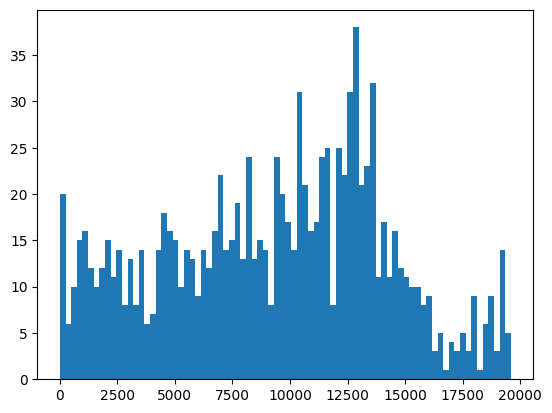

In [213]:
# histogram of all_lineups Ranks
plt.hist(all_lineups['Rank'], bins=80)

In [ ]:
len(all_lineups)

1900

In [ ]:
# how many in bad_lineups
len(bad_lineups)


174

In [ ]:
len(great_lineups)

#great_lineups[2]

20

In [ ]:
great_and_bad_lineups_hitters = pd.DataFrame()
great_and_bad_lineups_pitchers = pd.DataFrame()
great_and_bad_lineups = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(great_lineups)):
    # get each lineup individually
    this_lineup_avgs = great_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])

for i in range(len(bad_lineups)):
    # do the same but set great_lineup to 0
    this_lineup_avgs = bad_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 0
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)

    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()

    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])
    
    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={ 'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])


In [ ]:
great_and_bad_lineups.head()

,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup,player_drafted_pred_pitcher,payoff_pred_pitcher,opp_mean_pred_pitcher,team_batter_fp_pred_pitcher,player_fp_pred_pitcher,WHIP_pitcher,est_woba_pitcher,est_slg_pitcher,hr_friendly_launch_speed_pitcher_pitcher,hr_friendly_launch_angle_pitcher_pitcher,batter_fp_pred_pitcher,pitcher_fp_pred_pitcher,team_batter_fp_pred_pitcher,team_batter_salary_pitcher,batter_drafted_pred_pitcher,pitcher_drafted_pred_pitcher,opp_pitcher_drafted_mean_pitcher,opp_batter_drafted_mean_pitcher,pitcher_payoff_pred_pitcher,Salary_pitcher,AvgPointsPerGame_pitcher
0,10.40,11.98,6.94,70.28,8.35,1.63,0.32,0.42,0.18,0.08,8.35,7.22,70.28,37225.00,10.40,9.56,9.23,10.43,5.45,4450.00,6.91,1.00,15.72,10.70,6.32,56.89,16.87,1.06,0.28,0.31,0.14,0.06,4.31,17.75,56.89,36250.00,3.39,17.28,15.72,6.10,9.12,7050.00,11.08
0,9.54,11.17,11.21,63.70,7.72,1.33,0.32,0.41,0.19,0.07,7.72,10.75,63.70,37287.50,9.54,12.11,12.92,9.15,6.96,4337.50,7.19,1.00,14.90,11.53,6.41,57.70,13.46,1.19,0.34,0.43,0.18,0.08,6.56,12.10,57.70,36350.00,7.16,11.63,14.90,8.09,7.74,7650.00,14.35
0,7.56,9.65,7.81,80.41,8.21,1.60,0.34,0.45,0.15,0.07,8.21,6.57,80.41,41462.50,7.56,3.35,5.34,7.01,1.93,3850.00,6.69,1.00,21.44,8.55,5.97,53.75,18.51,0.99,0.35,0.47,0.14,0.04,6.63,15.52,53.75,37250.00,2.98,16.17,21.44,1.93,6.33,9600.00,21.13
0,6.65,11.35,8.72,84.99,8.18,1.53,0.34,0.46,0.16,0.08,8.18,7.63,84.99,47100.00,6.65,4.30,6.22,6.81,1.14,3962.50,6.71,1.00,17.44,8.44,6.13,55.20,18.07,0.98,0.37,0.54,0.14,0.07,8.27,15.70,55.20,35000.00,5.76,13.27,17.44,2.74,6.51,9000.00,19.44
0,7.72,9.24,6.59,77.84,7.92,1.50,0.33,0.45,0.23,0.08,7.92,5.15,77.84,43725.00,7.72,0.84,2.72,7.46,1.00,4012.50,6.79,1.00,17.40,8.89,6.07,51.76,17.39,1.04,0.34,0.46,0.14,0.07,7.58,15.78,51.76,30900.00,5.88,14.57,17.40,3.13,7.00,8900.00,17.29


In [ ]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 1]


,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,10.40,11.98,6.94,70.28,8.35,1.63,0.32,0.42,0.18,0.08,8.35,7.22,70.28,37225.00,10.40,9.56,9.23,10.43,5.45,4450.00,6.91,1.00
0,9.54,11.17,11.21,63.70,7.72,1.33,0.32,0.41,0.19,0.07,7.72,10.75,63.70,37287.50,9.54,12.11,12.92,9.15,6.96,4337.50,7.19,1.00
0,7.56,9.65,7.81,80.41,8.21,1.60,0.34,0.45,0.15,0.07,8.21,6.57,80.41,41462.50,7.56,3.35,5.34,7.01,1.93,3850.00,6.69,1.00
0,6.65,11.35,8.72,84.99,8.18,1.53,0.34,0.46,0.16,0.08,8.18,7.63,84.99,47100.00,6.65,4.30,6.22,6.81,1.14,3962.50,6.71,1.00
0,7.72,9.24,6.59,77.84,7.92,1.50,0.33,0.45,0.23,0.08,7.92,5.15,77.84,43725.00,7.72,0.84,2.72,7.46,1.00,4012.50,6.79,1.00
0,5.26,11.11,14.79,85.82,7.62,1.09,0.35,0.47,0.15,0.09,7.62,13.47,85.82,52587.50,5.26,6.85,8.33,5.35,2.01,4775.00,7.94,1.00
0,6.76,7.70,11.67,58.84,7.96,1.36,0.33,0.44,0.16,0.08,7.96,11.41,58.84,32725.00,6.76,13.00,13.44,6.24,5.87,4362.50,7.45,1.00
0,7.49,8.58,11.16,62.96,7.55,1.32,0.33,0.44,0.16,0.09,7.55,10.47,62.96,36825.00,7.49,9.15,10.37,6.95,5.34,4237.50,7.07,1.00
0,7.01,8.09,12.06,63.07,7.65,1.29,0.33,0.41,0.16,0.08,7.65,11.58,63.07,37425.00,7.01,9.96,10.89,6.42,5.75,4312.50,7.37,1.00
0,4.90,7.81,11.53,56.30,7.50,1.15,0.34,0.45,0.19,0.08,7.50,10.51,56.30,35512.50,4.90,4.14,5.94,4.83,4.44,4650.00,7.65,1.00


In [ ]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 0]


,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,7.87,10.40,13.78,59.94,7.96,1.13,0.36,0.47,0.17,0.06,7.96,13.02,59.94,38112.50,7.87,13.47,14.80,6.69,6.76,4712.50,8.23,0.00
0,3.46,11.48,9.68,67.56,7.89,1.35,0.33,0.42,0.18,0.07,7.89,10.52,67.56,39200.00,3.46,1.47,1.51,3.36,-0.36,4237.50,7.81,0.00
0,6.62,7.49,13.18,55.37,7.64,1.21,0.34,0.44,0.14,0.07,7.64,12.92,55.37,33362.50,6.62,17.11,17.57,5.23,5.50,4362.50,7.56,0.00
0,5.25,9.22,14.17,61.62,8.22,1.13,0.35,0.46,0.13,0.07,8.22,13.56,61.62,37887.50,5.25,17.34,18.42,4.92,4.75,4762.50,8.33,0.00
0,4.98,7.75,13.99,58.27,7.62,1.23,0.32,0.40,0.14,0.07,7.62,14.72,58.27,34412.50,4.98,22.57,21.28,4.62,5.10,4362.50,7.34,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,5.37,8.23,12.38,63.48,7.95,1.34,0.32,0.43,0.14,0.07,7.95,11.12,63.48,35037.50,5.37,9.69,11.90,4.94,4.60,4225.00,7.48,0.00
0,5.86,8.12,12.05,62.64,7.83,1.32,0.33,0.45,0.18,0.09,7.83,11.80,62.64,35787.50,5.86,9.82,9.05,4.83,4.10,4250.00,7.05,0.00
0,6.23,7.80,10.55,65.64,7.96,1.36,0.34,0.45,0.17,0.08,7.96,10.20,65.64,34987.50,6.23,6.84,7.24,5.40,3.67,4225.00,7.35,0.00
0,5.32,9.30,11.01,68.46,8.59,1.51,0.33,0.41,0.16,0.04,8.59,9.99,68.46,35987.50,5.32,11.44,12.85,4.91,4.15,4375.00,7.60,0.00


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.04921
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.19980
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.09616
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.17714
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.12142
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

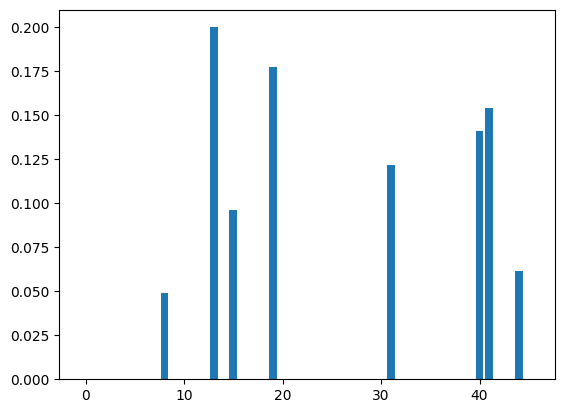

array([[33,  1],
       [ 2,  3]], dtype=int64)

In [ ]:
# commenting out 'great_lineup' prediction model since it does not seem to be working correctly

# create a model to predict if a lineup is a great lineup based on pregame factors
# # target is great_lineup, features are pregame factors
target = great_and_bad_lineups['great_lineup']
# # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
feature_names = great_and_bad_lineups.columns[great_and_bad_lineups.columns != 'great_lineup']
features = great_and_bad_lineups[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup = LinearRegression()

# # fit the model
# model_is_great_lineup.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup.predict(X_test)

# # calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))

# print('Model R2: ', r2)
# print('Model RMSE: ', rmse)

# # importance of each feature
# importance = model_is_great_lineup.coef_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# do the above for a decision tree classifier model

# establish a model
model_is_great_lineup = DecisionTreeClassifier()

# fit the model
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)
model_is_great_lineup.fit(X_train, y_train)
importance = model_is_great_lineup.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


y_pred = model_is_great_lineup.predict(X_test)
confusion_matrix(y_test, y_pred)


In [ ]:


# build a classification model to predict if a lineup is a great lineup
# # target is great_lineup, features are pregame factors
# target = great_and_bad_lineups_pitchers['great_lineup']
# # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = [ 'opp_mean_pred', 'player_fp_pred', 'WHIP', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'payoff_pred', 'Salary']
# features = great_and_bad_lineups_pitchers[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup_pitchers = LogisticRegression()

# # fit the model
# model_is_great_lineup_pitchers.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup_pitchers.predict(X_test)

# confusion_matrix(y_test, y_pred)



In [ ]:
lineups_hitters = pd.DataFrame()
lineups_pitchers = pd.DataFrame()
cashing_or_not = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])

for i in range(len(non_cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = non_cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 0
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])



Feature: player_drafted_pred, Score: 0.05033
Feature: payoff_pred, Score: 0.00000
Feature: opp_mean_pred, Score: 0.03559
Feature: team_batter_fp_pred, Score: 0.00000
Feature: team_batter_fp_pred, Score: 0.00269
Feature: player_fp_pred, Score: 0.02786
Feature: WHIP, Score: 0.05677
Feature: est_woba, Score: 0.02373
Feature: est_slg, Score: 0.05159
Feature: hr_friendly_launch_speed_pitcher, Score: 0.05073
Feature: hr_friendly_launch_angle_pitcher, Score: 0.02843
Feature: batter_fp_pred, Score: 0.01167
Feature: pitcher_fp_pred, Score: 0.01794
Feature: team_batter_fp_pred, Score: 0.01614
Feature: team_batter_fp_pred, Score: 0.01853
Feature: team_batter_salary, Score: 0.07731
Feature: batter_drafted_pred, Score: 0.02011
Feature: pitcher_drafted_pred, Score: 0.03305
Feature: opp_pitcher_drafted_mean, Score: 0.02521
Feature: opp_batter_drafted_mean, Score: 0.02932
Feature: pitcher_payoff_pred, Score: 0.02338
Feature: Salary, Score: 0.00971
Feature: AvgPointsPerGame, Score: 0.02172
Feature: pla

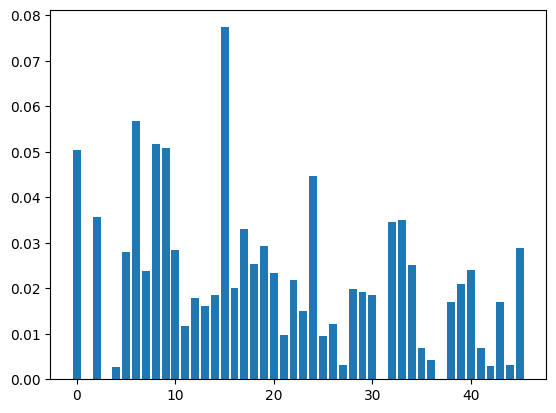

array([[217,  63],
       [ 49,  51]], dtype=int64)

In [ ]:
# classification model to predict if a lineup is a cashing lineup
# target is cashing_lineup, features are pregame factors
target = cashing_or_not['cashing_lineup']
# feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
feature_names = cashing_or_not.columns[cashing_or_not.columns != 'cashing_lineup']
features = cashing_or_not[feature_names]
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# establish a model
model_is_cashing_lineup = DecisionTreeClassifier()

# fit the model
model_is_cashing_lineup.fit(X_train, y_train)
importance = model_is_cashing_lineup.feature_importances_
names = model_is_cashing_lineup.feature_names_in_

# summarize feature importance
for i,v in enumerate(importance):
    # print feature name
    print('Feature: %s, Score: %.5f' % (names[i],v))
    #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# predict the model
y_pred = model_is_cashing_lineup.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
# change to True to run the following code
if False:
    best_lineup = pd.DataFrame()
    best_lineup_rank = 100000

    for i in range(150):
        lineup = build_one_lineup(all_variables)
        # get only variables for players with names in lineup_players
        lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

        # add a dummy column to lineup_vars to groupby
        lineup_vars['Rank'] = 'dummy'

        lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
        lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

        lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
        lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

        # rename pitcher columns by suffixing with '_pitcher'
        lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
        lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

        # merge hitters and pitchers on Rank and Date
        combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

        # drop Rank
        combined_vars = combined_vars.drop(columns='Rank')
        
        # get rank predictions
        lineup_rank_prediction = model.predict(combined_vars)
        lineup_rank_prediction = lineup_rank_prediction[0]

        if lineup_rank_prediction < best_lineup_rank:
            best_lineup = lineup

    best_lineup

In [ ]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
lineups_to_build = 100
# def backtest_with_models():
files = get_files()

# read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

all_sum_fpts = []
all_lineup_ranks = []
all_lineup_payoffs = []
#all_lineup_utilities = []
all_lineup_rank_preds = []
keepers = []
# create a table for earnings per day
earnings = pd.DataFrame()
all_lineups = pd.DataFrame()

for file in files:
    # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
    if 'MLBContestStandings' in file:
        date = file[-12:-4]
        m = str(date[0:2])
        d = str(date[2:4])
        y = str(date[4:8])
        # break if date is 06/02
        #if int(d) > 2 and int(m) == 6:
        if not (m == '06' and d == '02'):
            todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
            print('Getting data for ', m, d, y)
            contest_data = get_contest_standings(y, m, d)
            contest_player_results = get_contest_results(contest_data)
            leaderboard = get_leaderboard(contest_data)
            # skip if leaderboard has > 20000 rows or < 13000 rows
            if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
                # change 'Player' to 'Name' in contest_player_results
                contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
                #someday will implement this rather than the below scripting, but for now keeping things as before
                #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                all_variables = get_all_variables(y, m, d, optional='', df=df)

                payoff_total = 0
                # max_fpts = 0
                # max_lineup_rank = 100000
                
                # define an empty array to store lineups that rank > 14000
                
                # build lineups until lineups_to_build is reached
                pbar = tqdm(desc="while loop", total=lineups_to_build)
                i= 0
                while i < lineups_to_build:
                    lineup = build_one_lineup(all_variables, all_variables)                        
                    # get only variables for players with names in lineup_players
                    lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

                    # add a dummy column to lineup_vars to groupby
                    lineup_vars['Rank'] = 'dummy'

                    lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
                    lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

                    lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
                    lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

                    # rename pitcher columns by suffixing with '_pitcher'
                    lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
                    lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

                    # merge hitters and pitchers on Rank and Date
                    combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

                    # drop Rank
                    rank_model_vars = combined_vars[['batting_order', 'avg_batter_fp', 'avg_batting_order', 'est_woba',
                        'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
                        'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
                        'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
                        'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
                        'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
                        'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
                        'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
                        'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame',
                        'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred',
                        'batting_order_pitcher', 'avg_batter_fp_pitcher',
                        'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
                        'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
                        'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
                        'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
                        'hr_friendly_launch_angle_pitcher_pitcher',
                        'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
                        'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
                        'teams_in_game_pk_pitcher', 'is_of_pitcher',
                        'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
                        'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
                        'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
                        'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
                        'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
                        'player_drafted_pred_pitcher', 'payoff_pitcher',
                        'opp_mean_pred_pitcher']]
                    
                    # if combined_vars is empty, skip to next iteration
                    if rank_model_vars.empty:
                        continue

                    #rank_model_vars = update_rank_model(rank_model_vars)
                    
                    great_lineup_vars = combined_vars[model_is_cashing_lineup.feature_names_in_]
                    # get rank predictions
                    lineup_rank_prediction = model.predict(normalize_features(rank_model_vars))[0]
                    great_lineup_prediction = model_is_great_lineup.predict(great_lineup_vars)[0]
                    cashing_lineup_prediction = model_is_cashing_lineup.predict(great_lineup_vars)[0]

                    if great_lineup_prediction == 0 and cashing_lineup_prediction == 0:
                        continue
                    else:
                        # get actual fpts for lineup based on contest_player_results
                        lineup['fpts'] = lineup['Name'].map(contest_player_results)
                        lineup_fpts = lineup['fpts'].sum()

                        # get rank of lineup in leaderboard
                        lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
                        keepers.append(lineup)

                        # get payoff based on rank
                        this_payoff = get_payoff(lineup_rank)

                        # add current results to arrays
                        all_sum_fpts.append(lineup['player_fp_pred'].sum())
                        all_lineup_ranks.append(lineup_rank)
                        all_lineup_payoffs.append(this_payoff)
                        #all_lineup_utilities.append(lineup['Utility'].sum())
                        all_lineup_rank_preds.append(lineup_rank_prediction)

                        # add to todays_lineups
                        todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                        i = len(todays_lineups)

                    pbar.update(1)
                pbar.close()
                # get the payoff_total for all generated lineups
                payoff_total_all = todays_lineups['Payoff'].sum()
                
                # add to all_lineups
                all_lineups = pd.concat([all_lineups, todays_lineups])

                # add to earnings table
                timestamp = datetime.datetime.now().time()
                earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'GeneratedAt': [timestamp], 'Filtered Lineups Earnings': [payoff_total_all]})])

#     return all_lineups, earnings, keepers

# lineups, earnings, keepers = backtest_with_models()
earnings

Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


while loop: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Getting data for  05 28 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [06:38<00:00,  3.99s/it]


Getting data for  05 29 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


while loop: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Getting data for  05 30 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05302024.csv
Getting data for  05 31 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


while loop: 100%|██████████| 100/100 [05:36<00:00,  3.37s/it]


Getting data for  06 03 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [04:30<00:00,  2.71s/it]


Getting data for  06 04 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


Getting data for  06 05 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Getting data for  06 06 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06062024.csv
Getting data for  06 07 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [20:30<00:00, 12.30s/it]


Getting data for  06 08 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [04:34<00:00,  2.75s/it]


Getting data for  06 09 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [08:29<00:00,  5.10s/it]


Getting data for  06 10 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


while loop: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


Getting data for  06 11 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [07:49<00:00,  4.70s/it]


Getting data for  06 12 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06122024.csv
Getting data for  06 13 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06132024.csv
Getting data for  06 14 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


while loop: 100%|██████████| 100/100 [08:37<00:00,  5.17s/it]


Getting data for  06 15 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Getting data for  06 16 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


while loop: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Getting data for  06 17 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Getting data for  06 18 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [05:47<00:00,  3.47s/it]


Getting data for  06 19 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06192024.csv
Getting data for  06 20 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06202024.csv
Getting data for  06 21 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [06:03<00:00,  3.63s/it]


Getting data for  06 22 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


,Date,GeneratedAt,Filtered Lineups Earnings
0,05272024,12:32:56.257431,-595
0,05282024,12:40:18.503925,-210
0,05292024,12:41:53.659917,470
0,05312024,12:48:15.511697,325
0,06032024,12:53:35.339583,-780
0,06042024,12:57:26.810089,3765
0,06052024,12:59:35.154344,34005
0,06072024,13:20:56.369978,-955
0,06082024,13:26:22.479962,-870
0,06092024,13:35:44.187321,-700


In [ ]:
# get pct earnings for each day
pct_earnings = earnings.copy()
pct_earnings['Filtered Lineups Earnings'] = pct_earnings['Filtered Lineups Earnings'].astype(float)/(lineups_to_build*15)*100
print("Sum filtered lineups earnings: ", pct_earnings['Filtered Lineups Earnings'].sum())

Sum filtered lineups earnings:  2068.6666666666665


In [ ]:
len(keepers)/len(all_lineups) * 100 # percentage of lineups kept

100.0

In [ ]:
# get all variables - refreshes default data before building

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]

# optional = ''

# pregame_data = get_pregame_info(df, year, month, day)
# all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

# all_variables = get_all_variables(year, month, day, optional='', df=df)

In [ ]:
# save models to disk
pickle.dump(model_is_great_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'wb'))
pickle.dump(model_is_cashing_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'wb'))

In [ ]:
# display floats to 1 decimal
pd.options.display.float_format = '{:.3f}'.format
all_variables[(all_variables['team'] == 'CIN')].sort_values(by='player_fp_pred', ascending=False)


,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,value
47,Frankie Montas,8.000,SS,5.553,7.184,0.306,0.382,0.259,0.114,0.051,100.000,1.390,0.187,0.056,-0.816,6.307,9.952,67.093,15.000,0.000,35400.000,4.983,7.252,12.545,8.979,6.959,5.748,david hamilton,frankie montas,SP,Frankie Montas (34733554),34733554,P,6000,BOS@CIN 06/22/2024 04:10PM ET,CIN,10.070,frankie montas,10.933,8.979,5.748,BOS,7.455,1.822
63,Jeimer Candelario,2.000,1B/3B,8.060,4.561,0.305,0.409,0.236,0.131,0.055,110.000,1.130,0.145,0.093,2.561,7.540,17.064,48.168,15.000,1.000,32200.000,6.794,25.273,6.519,24.659,4.813,7.298,jeimer candelario,nick pivetta,1B/3B,Jeimer Candelario (34733613),34733613,1B/3B,4200,BOS@CIN 06/22/2024 04:10PM ET,CIN,7.810,jeimer candelario,7.540,6.794,6.519,BOS,16.716,1.795
124,Spencer Steer,3.000,1B,7.603,3.708,0.335,0.426,0.251,0.139,0.079,110.000,1.130,0.145,0.093,0.708,7.360,14.518,48.168,15.000,0.000,32200.000,5.904,20.790,6.566,24.659,4.813,7.298,spencer steer,nick pivetta,1B,Spencer Steer (34733587),34733587,1B,4600,BOS@CIN 06/22/2024 04:10PM ET,CIN,7.710,spencer steer,7.360,5.904,6.566,BOS,16.716,1.600
42,Elly De La Cruz,1.000,SS,7.293,3.189,0.331,0.431,0.230,0.168,0.047,110.000,1.130,0.145,0.093,2.189,7.121,16.567,48.168,15.000,0.000,32200.000,8.178,24.398,6.181,24.659,4.813,7.298,elly de la cruz,nick pivetta,SS,Elly De La Cruz (34733560),34733560,SS,6200,BOS@CIN 06/22/2024 04:10PM ET,CIN,9.840,elly de la cruz,7.121,8.178,6.181,BOS,16.716,1.149
70,Jonathan India,5.000,2B,6.618,4.676,0.343,0.377,0.276,0.120,0.062,110.000,1.130,0.145,0.093,-0.324,6.533,11.114,48.168,15.000,0.000,32200.000,4.066,14.798,6.181,24.659,4.813,7.298,jonathan india,nick pivetta,2B,Jonathan India (34733667),34733667,2B,3500,BOS@CIN 06/22/2024 04:10PM ET,CIN,6.620,jonathan india,6.533,4.066,6.181,BOS,16.716,1.867
107,Nick Martini,6.000,OF,5.816,6.794,0.266,0.336,0.211,0.105,0.075,110.000,1.130,0.145,0.093,0.794,5.538,19.898,48.168,15.000,1.000,32200.000,3.505,30.262,5.794,24.659,4.813,7.298,nick martini,nick pivetta,OF,Nick Martini (34733644),34733644,OF,3700,BOS@CIN 06/22/2024 04:10PM ET,CIN,5.220,nick martini,5.538,3.505,5.794,BOS,16.716,1.497
136,Will Benson,8.000,OF,5.457,5.613,0.285,0.353,0.195,0.134,0.046,110.000,1.130,0.145,0.093,-2.387,5.423,20.516,48.168,15.000,1.000,32200.000,2.189,31.349,5.306,24.659,4.813,7.298,will benson,nick pivetta,OF,Will Benson (34733694),34733694,OF,3200,BOS@CIN 06/22/2024 04:10PM ET,CIN,5.660,will benson,5.423,2.189,5.306,BOS,16.716,1.695
57,Jake Fraley,4.000,OF,4.386,4.979,0.288,0.322,0.251,0.098,0.067,110.000,1.130,0.145,0.093,0.979,4.418,15.138,48.168,15.000,1.000,32200.000,4.122,21.883,6.141,24.659,4.813,7.298,jake fraley,nick pivetta,OF,Jake Fraley (34733623),34733623,OF,4100,BOS@CIN 06/22/2024 04:10PM ET,CIN,5.460,jake fraley,4.418,4.122,6.141,BOS,16.716,1.077
91,Luke Maile,7.000,C,4.061,8.586,0.287,0.312,0.204,0.072,0.072,110.000,1.130,0.145,0.093,1.586,4.235,18.909,48.168,15.000,0.000,32200.000,3.745,28.521,6.150,24.659,4.813,7.298,luke maile,nick pivetta,C,Luke Maile (34733741),34733741,C,2700,BOS@CIN 06/22/2024 04:10PM ET,CIN,3.880,luke maile,4.235,3.745,6.150,BOS,16.716,1.569


Mass Multi Entry Builder

In [216]:

# build a csv of dk lineups using get_best_lineup
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]

# Number of lineups at the end
lineups_to_build = 104
# Number of lineups to build, of which we select the best ranked lineups_to_build
# iterations = 200
# banned players by name
bans = []
# Max percent of lineups that should include a single player
# max_own_goal = 0.7
# sets the standard deviation for the normal distribution used to select players
stdev = 9

# year, month day, optional and df are all defined above
optional = ''
# def build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df):
# get all variables - refreshes default data before building

#all_variables = get_all_variables(year, month, day, optional, df=df)
all_variables['ID'] = all_variables['ID'].astype(str)
# bans = ['William Contreras', 'Connor Wong', 'Jose Trevino', 'TB', 'MIN']

# all_variables = all_variables[~all_variables['Name'].isin(bans)]
# all_variables = all_variables[~all_variables['team'].isin(bans)]

temp_col_names = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 'Rank_pred', 'key']
column_names = ['P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
lineups = pd.DataFrame(columns=temp_col_names)
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
model_is_cashing_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'rb'))
model_is_great_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'rb'))

# # create a dictionary to store number of times each id is in a lineup
# id_counts = dict.fromkeys(all_variables['ID'], 0)
# # get max number of times a player can be in a lineup
# max_id_count = int(lineups_to_build * max_own_goal)

pbar = tqdm(total=lineups_to_build, desc="while loop")
i = 0
counter = 0
while i < lineups_to_build:
    # add progress bar to loop with tqdm
    counter += 1
    lineup_vars = build_one_lineup(all_variables, bans=bans, stdev=stdev)
    
    for col in lineup_vars.columns:
        if col == 'ID':
            continue
        try:
            lineup_vars[col] = lineup_vars[col].astype(float)
        except:
            continue        
    # add a dummy column to lineup_vars to groupby
    lineup_vars['Rank'] = 'dummy'

    lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
    lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

    lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
    lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

    # rename pitcher columns by suffixing with '_pitcher'
    lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
    lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

    # merge hitters and pitchers on Rank and Date
    combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

    # drop Rank
    combined_vars = combined_vars.drop(columns=['Rank'])

    #combined_vars = update_rank_model(combined_vars)
    rank_model_vars = combined_vars[pregame_rank_model_features]

    great_lineup_vars = combined_vars[model_is_cashing_lineup.feature_names_in_]
    # get rank predictions
    lineup_rank_prediction = model.predict(normalize_features(rank_model_vars))[0]
    great_lineup_prediction = model_is_great_lineup.predict(great_lineup_vars)[0]
    cashing_lineup_prediction = model_is_cashing_lineup.predict(great_lineup_vars)[0]

    if great_lineup_prediction == 0 and cashing_lineup_prediction == 0:
         continue
    else:
        # alphabetize IDs, concatenate as single string, add to lineup as key
        alphabetized_ids = lineup_vars['ID'].astype(str).sort_values().tolist()
        alphabetized_ids = ''.join(alphabetized_ids)

        # add lineup prediction to lineup ids
        ids = lineup_vars['ID'].tolist()

        ids.append(lineup_rank_prediction)
        ids.append(alphabetized_ids)
        pre = len(lineups)
        lineups = pd.concat([lineups, pd.DataFrame([ids], columns=temp_col_names)])
        # drop duplicates
        lineups = lineups.drop_duplicates(subset='key') 
        i = len(lineups)
        if i > pre:
            pbar.update(1)
pbar.close()

# # get the best 'lineups_to_build' lineups based on rank prediction
# lineups = lineups.sort_values(by='Rank_pred').head(lineups_to_build)

# get lineup ids
lineups = lineups.drop(columns=['Rank_pred', 'key'])

# rename columns
lineups.columns = column_names
# return lineups

# lineups = build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
# save lineups to csv
lineups.to_csv('C:\\Users\\jorda\\Downloads\\lineups.csv', index=False)

while loop:   0%|          | 0/104 [00:20<?, ?it/s]


KeyboardInterrupt: 

In [217]:

print('Great lineup prediction: ', great_lineup_prediction, '\nCashing lineup prediction: ', cashing_lineup_prediction, '\nLineups for export: ', len(lineups), '\nLineups built: ', counter)


Great lineup prediction:  1.0 
Cashing lineup prediction:  1.0 
Lineups for export:  98 
Lineups built:  989


In [ ]:
def write_to_entries():
    # import from DKEntriesMLB.csv
    # use columns  0 - 16
    entries = pd.read_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', sep=",", header=0, names=range(14), usecols=range(14))
    # change column names to original
    entries = entries.drop(columns=range(4, 14))
   
    # replace columns 4-13 with IDs from 'C:\\Users\\jorda\\Downloads\\lineups.csv'
    new_lineups = pd.read_csv('C:\\Users\\jorda\\Downloads\\lineups.csv')
    # make new_lineups all strings
    new_lineups = new_lineups.astype(str)
    entries = entries.astype(str)
    entries = pd.concat([entries, new_lineups], axis=1)
    # remove NaNs
    entries.columns = ['Entry ID', 'Contest Name', 'Contest ID', 'Entry Fee', 'P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
    entries = entries.dropna()
     # remove decimals from first column if there is a decimal
    entries.replace('\.0', '', regex=True, inplace=True)

    # remove scientific notation
    pd.options.display.float_format = '{:.0f}'.format
    # write to csv, do not include index
    entries.to_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', index=False)
    return entries
entries = write_to_entries()

In [218]:
def check_ownership(lineups, top_own = 20):
    num_built = lineups.shape[0]
    # check number of times each player is in lineups and sort by most to least
    ownership = lineups.stack().value_counts().reset_index()
    ownership = ownership.rename(columns={'index': 'ID', 0: 'count'})
    ownership = ownership.sort_values(by='count', ascending=False)
    ownership = pd.merge(ownership, all_variables[['ID', 'Name', 'team', 'position']], on='ID')
    # calculate percentage of lineups each player is in, rounded to 2 decimal places
    ownership['percentage'] = (ownership['count'] / num_built) * 100
    print(ownership.head(top_own))

check_ownership(lineups, top_own=40)


          ID  count               Name team position  percentage
0   34850174     54     MacKenzie Gore  WSH        P       55.10
1   34850076     49      Rob Zastryzny  MIL        P       50.00
2   34850089     48      Austin Gomber  COL        P       48.98
3   34850096     45     David Peterson  NYM        P       45.92
4   34850114     42    Brendan Rodgers  COL       2B       42.86
5   34850077     39       Ryan McMahon  COL       3B       39.80
6   34850225     37         Joey Ortiz  MIL       3B       37.76
7   34850028     37   Christian Yelich  MIL       OF       37.76
8   34850065     36     Harold Ramirez  WSH       OF       36.73
9   34850109     33  William Contreras  MIL        C       33.67
10  34850007     32   Charlie Blackmon  COL       OF       32.65
11  34850013     32      J.D. Martinez  NYM    1B/OF       32.65
12  34850201     31       Brice Turang  MIL       2B       31.63
13  34850022     31         Elias Diaz  COL        C       31.63
14  34850111     29      